In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from datetime import datetime
import os
import pickle
from scipy.sparse import csr_matrix
import operator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2nd try graphsage

In [17]:
# Graph sage : Training completed. Best HR: 0.6124, Best NDCG: 0.3914


class GraphSAGERecommender(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(GraphSAGERecommender, self).__init__()
        
        # Increase embedding dimensions
        self.embedding_dim = embedding_dim
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Add batch normalization
        self.bn_user = nn.BatchNorm1d(embedding_dim)
        self.bn_item = nn.BatchNorm1d(embedding_dim)
        
        # Deeper MLP with residual connections
        self.layers = nn.ModuleList()
        input_dim = embedding_dim * 2
        
        for i in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
        
        # Prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim + embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, user_ids, item_ids):
        # Get and normalize embeddings
        user_emb = self.bn_user(self.user_embedding(user_ids))
        item_emb = self.bn_item(self.item_embedding(item_ids))
        
        # Initial concatenation
        x = torch.cat([user_emb, item_emb], dim=1)
        
        # Store original input for residual connection
        original_input = x
        
        # Pass through MLP layers with residual connections
        for layer in self.layers:
            x = layer(x) + x if x.size() == layer(x).size() else layer(x)
        
        # Concatenate with original embeddings for final prediction
        x = torch.cat([x, original_input], dim=1)
        return self.predictor(x).squeeze()


class BeibeiDataset(Dataset):
    def __init__(self, file_path, num_negative=8):  # Increased negative samples
        self.data = pd.read_csv(file_path, sep=' ', header=None, names=['user_id', 'item_id', 'label'], skiprows=1)
        
        # Create mappings
        self.user_map = {id_: idx for idx, id_ in enumerate(self.data['user_id'].unique())}
        self.item_map = {id_: idx for idx, id_ in enumerate(self.data['item_id'].unique())}
        
        # Map IDs
        self.data['user_id'] = self.data['user_id'].map(self.user_map)
        self.data['item_id'] = self.data['item_id'].map(self.item_map)
        
        self.num_users = len(self.user_map)
        self.num_items = len(self.item_map)
        self.num_negative = num_negative
        
        # Create user-items dictionary
        self.user_items = self.create_user_items_dict()
        
        # Add negative samples with improved sampling strategy
        self.data = self.add_negative_samples()
        
    def create_user_items_dict(self):
        return {user_id: set(self.data[self.data['user_id'] == user_id]['item_id']) 
                for user_id in range(self.num_users)}
        
    def add_negative_samples(self):
        negative_samples = []
        all_items = set(range(self.num_items))
        
        # Calculate item popularity
        item_counts = self.data['item_id'].value_counts()
        item_probs = 1 / (item_counts + 1)  # Add 1 to avoid division by zero
        item_probs = item_probs / item_probs.sum()
        
        for user_id in self.user_items:
            pos_items = self.user_items[user_id]
            neg_items = list(all_items - pos_items)
            
            if len(neg_items) > 0:
                # Calculate sampling probabilities for negative items
                neg_probs = item_probs[neg_items]
                neg_probs = neg_probs / neg_probs.sum()
                
                # Sample negative items based on popularity
                num_neg = min(len(neg_items), self.num_negative)
                sampled_neg = np.random.choice(
                    neg_items, 
                    size=num_neg, 
                    replace=False,
                    p=neg_probs
                )
                
                for item_id in sampled_neg:
                    negative_samples.append([user_id, item_id, 0])
        
        neg_df = pd.DataFrame(negative_samples, columns=['user_id', 'item_id', 'label'])
        return pd.concat([self.data, neg_df], ignore_index=True).sample(frac=1)


# First, initialize the dataset
print("Loading dataset...")
file_path = '/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt'
dataset = BeibeiDataset(file_path)

# Print dataset statistics
print(f"Number of users: {dataset.num_users}")
print(f"Number of items: {dataset.num_items}")
print(f"Total interactions: {len(dataset.data)}")

# Training configuration
config = {
    'embedding_dim': 128,
    'hidden_dim': 256,
    'num_layers': 3,
    'dropout': 0.3,
    'batch_size': 1,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'num_epochs': 30
}

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGERecommender(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    embedding_dim=config['embedding_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
).to(device)

# Optimizer and scheduler setup
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['num_epochs'],
    eta_min=1e-6
)

Loading dataset...
Number of users: 21716
Number of items: 3101
Total interactions: 195444


In [18]:
def evaluate_model(model, test_loader, k=10):
    """
    Evaluate the model using HR@k and NDCG@k
    """
    hits = []
    ndcgs = []
    
    model.eval()
    with torch.no_grad():
        for user_ids, item_ids, labels in test_loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            
            # Get positive items (where label == 1)
            positive_mask = labels == 1
            test_users = user_ids[positive_mask]
            test_items = item_ids[positive_mask]
            
            for user_id, true_item in zip(test_users, test_items):
                # Generate 99 negative items + 1 positive item
                neg_items = torch.tensor([i for i in range(dataset.num_items) if i != true_item])
                neg_items = neg_items[torch.randperm(len(neg_items))[:99]]
                eval_items = torch.cat([neg_items, true_item.unsqueeze(0)])
                
                # Create user tensor of same length as eval_items
                user_tensor = user_id.repeat(100).to(device)
                item_tensor = eval_items.to(device)
                
                # Get predictions
                predictions = model(user_tensor, item_tensor)
                
                # Get ranking of the true item
                _, indices = torch.sort(predictions, descending=True)
                rank = (indices == 99).nonzero().item()  # 99 is the index of true_item
                
                # Calculate HR@k and NDCG@k
                hits.append(1 if rank < k else 0)
                ndcgs.append(1 / np.log2(rank + 2) if rank < k else 0)
    
    return np.mean(hits), np.mean(ndcgs)

In [25]:
# Graph sage : Training completed. Best HR: 0.6124, Best NDCG: 0.3914

class BeibeiDataset(Dataset):
    def __init__(self, file_path, num_negative=4):
        # Read the data
        self.data = pd.read_csv(file_path, sep=' ', header=None, names=['user_id', 'item_id', 'label'], skiprows=1)
        
        # Create mappings for user and item IDs
        self.user_map = {id_: idx for idx, id_ in enumerate(self.data['user_id'].unique())}
        self.item_map = {id_: idx for idx, id_ in enumerate(self.data['item_id'].unique())}
        
        # Map IDs to indices
        self.data['user_id'] = self.data['user_id'].map(self.user_map)
        self.data['item_id'] = self.data['item_id'].map(self.item_map)
        
        self.num_users = len(self.user_map)
        self.num_items = len(self.item_map)
        self.num_negative = num_negative
        
        # Create user-items dictionary
        self.user_items = self.create_user_items_dict()
        
        # Add negative samples
        self.data = self.add_negative_samples()
        
    def create_user_items_dict(self):
        user_items = {}
        for user_id in range(self.num_users):
            user_items[user_id] = set(self.data[self.data['user_id'] == user_id]['item_id'])
        return user_items
        
    def add_negative_samples(self):
        negative_samples = []
        all_items = set(range(self.num_items))
        
        for user_id in self.user_items:
            # Get items this user hasn't interacted with
            negative_items = list(all_items - self.user_items[user_id])
            
            # Sample negative items
            if len(negative_items) > 0:
                num_neg = min(len(negative_items), self.num_negative)
                sampled_neg = np.random.choice(negative_items, num_neg, replace=False)
                
                # Add negative samples
                for item_id in sampled_neg:
                    negative_samples.append([user_id, item_id, 0])
        
        # Convert to DataFrame and combine with positive samples
        neg_df = pd.DataFrame(negative_samples, columns=['user_id', 'item_id', 'label'])
        return pd.concat([self.data, neg_df], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return (
            torch.tensor(row['user_id'], dtype=torch.long),
            torch.tensor(row['item_id'], dtype=torch.long),
            torch.tensor(row['label'], dtype=torch.float)
        )

# Load and preprocess data
dataset = BeibeiDataset('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt')

# Create data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model with correct number of users and items
model = GraphSAGERecommender(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    embedding_dim=64,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2
).to(device)

# Rest of the training code remains the same
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
# Modified DataLoader with batch_size equal to dataset size
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Training loop without batches
best_hr = 0
best_ndcg = 0

for epoch in range(20):
    model.train()
    
    # Get all data at once
    user_ids, item_ids, labels = next(iter(train_loader))
    user_ids = user_ids.to(device)
    item_ids = item_ids.to(device)
    labels = labels.to(device)
    
    # Forward pass
    optimizer.zero_grad()
    outputs = model(user_ids, item_ids)
    loss = criterion(outputs, labels)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        hr, ndcg = evaluate_model(model, test_loader)
    
    print(f"HR@10: {hr:.4f} (Best: {best_hr:.4f})")
    print(f"NDCG@10: {ndcg:.4f} (Best: {best_ndcg:.4f})")
    
    # Update best metrics
    best_hr = max(best_hr, hr)
    best_ndcg = max(best_ndcg, ndcg)
    
    # Learning rate scheduling
    scheduler.step(loss.item())

print(f"Training completed. Best HR: {best_hr:.4f}, Best NDCG: {best_ndcg:.4f}")

# graph sage ++

In [ ]:
# Epoch 15, Loss: 0.1466, HR@10: 0.1048, NDCG@10: 0.0479



# import torch
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# from torch_geometric.data import Data
# from torch_geometric.nn import SAGEConv
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Load the BeibeiDataset
# dataset = BeibeiDataset('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt')

# # Get user and item IDs from the dataset
# user_ids = dataset.data['user_id'].values
# item_ids = dataset.data['item_id'].values

# # Create edges
# edge_index = torch.tensor([
#     [u for u in user_ids],  # User nodes
#     [i + dataset.num_users for i in item_ids]   # Item nodes (offset by num_users)
# ], dtype=torch.long)

# # Node features
# num_users = dataset.num_users
# num_items = dataset.num_items
# num_nodes = num_users + num_items
# x = torch.randn(num_nodes, 64)  # Increased feature dimension to match embedding_dim

# # Create PyTorch Geometric data object
# graph_data = Data(x=x, edge_index=edge_index)

# class ImprovedGraphSAGE(torch.nn.Module):
#     def __init__(self, num_users, num_items, embedding_dim, hidden_dim, dropout=0.3):
#         super(ImprovedGraphSAGE, self).__init__()
        
#         self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
#         self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)
        
#         self.conv1 = SAGEConv(embedding_dim, hidden_dim)
#         self.conv2 = SAGEConv(hidden_dim, hidden_dim)
#         self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        
#         self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
#         self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
#         self.bn3 = torch.nn.BatchNorm1d(hidden_dim)
        
#         self.predictor = torch.nn.Sequential(
#             torch.nn.Linear(hidden_dim * 2, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(dropout),
#             torch.nn.Linear(hidden_dim, 1)
#         )
        
#         self.dropout = dropout
#         self._init_weights()
        
#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, torch.nn.Linear):
#                 torch.nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     torch.nn.init.zeros_(m.bias)
#             elif isinstance(m, torch.nn.Embedding):
#                 torch.nn.init.normal_(m.weight, std=0.01)

#     def forward(self, x, edge_index, user_indices, item_indices):
#         # Get initial embeddings
#         user_emb = self.user_embedding(user_indices)
#         item_emb = self.item_embedding(item_indices)
        
#         # Update node features with embeddings
#         x = torch.cat([
#             self.user_embedding.weight,
#             self.item_embedding.weight
#         ], dim=0)
        
#         # Process through GraphSAGE layers
#         x = self.conv1(x, edge_index)
#         x = self.bn1(x)
#         x = F.leaky_relu(x)
#         x = F.dropout(x, p=self.dropout, training=self.training)
        
#         x = self.conv2(x, edge_index)
#         x = self.bn2(x)
#         x = F.leaky_relu(x)
#         x = F.dropout(x, p=self.dropout, training=self.training)
        
#         x = self.conv3(x, edge_index)
#         x = self.bn3(x)
#         x = F.leaky_relu(x)
        
#         # Get final embeddings
#         user_final = x[:num_users][user_indices]
#         item_final = x[num_users:][item_indices]
        
#         # Combine embeddings
#         combined = torch.cat([user_final, item_final], dim=1)
#         return self.predictor(combined).squeeze()

# def calculate_metrics(model, test_data, k=10):
#     hits = []
#     ndcgs = []
    
#     model.eval()
#     with torch.no_grad():
#         pos_samples = test_data[test_data['label'] == 1]
        
#         for _, row in pos_samples.iterrows():
#             user_idx = row['user_id']
#             true_item = row['item_id']
            
#             # Calculate scores for all items
#             user_tensor = torch.LongTensor([user_idx]).repeat(dataset.num_items).to(device)
#             item_tensor = torch.LongTensor(range(dataset.num_items)).to(device)
            
#             scores = model(graph_data.x, graph_data.edge_index, user_tensor, item_tensor)
            
#             # Get top-k items
#             _, top_items = torch.topk(scores, k)
#             top_items = top_items.cpu().numpy()
            
#             # Calculate metrics
#             hit = 1 if true_item in top_items else 0
#             hits.append(hit)
            
#             if hit:
#                 rank = np.where(top_items == true_item)[0][0]
#                 ndcg = 1 / np.log2(rank + 2)
#             else:
#                 ndcg = 0
#             ndcgs.append(ndcg)
    
#     return np.mean(hits), np.mean(ndcgs)

# # Setup device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# graph_data = graph_data.to(device)

# # Data splitting
# pos_data = dataset.data[dataset.data['label'] == 1]
# neg_data = dataset.data[dataset.data['label'] == 0]

# test_size_pos = int(0.2 * len(pos_data))
# train_pos = pos_data.iloc[:-test_size_pos]
# test_pos = pos_data.iloc[-test_size_pos:]

# test_size_neg = int(0.2 * len(neg_data))
# train_neg = neg_data.iloc[:-test_size_neg]
# test_neg = neg_data.iloc[-test_size_neg:]

# train_data = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)
# test_data = pd.concat([test_pos, test_neg]).sample(frac=1, random_state=42)

# print(f"Train set size: {len(train_data)}, positive samples: {len(train_pos)}")
# print(f"Test set size: {len(test_data)}, positive samples: {len(test_pos)}")

# # Initialize model
# model = ImprovedGraphSAGE(
#     num_users=dataset.num_users,
#     num_items=dataset.num_items,
#     embedding_dim=64,
#     hidden_dim=128
# ).to(device)

# # Training setup
# criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# # scheduler = torch.optim.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
# # Training loop
# best_hr = 0
# best_ndcg = 0

# for epoch in range(50):
#     model.train()
#     total_loss = 0
    
#     # Process in batches
#     batch_size = 1024
#     for start_idx in range(0, len(train_data), batch_size):
#         end_idx = min(start_idx + batch_size, len(train_data))
#         batch_data = train_data.iloc[start_idx:end_idx]
        
#         user_ids = torch.LongTensor(batch_data['user_id'].values).to(device)
#         item_ids = torch.LongTensor(batch_data['item_id'].values).to(device)
#         labels = torch.FloatTensor(batch_data['label'].values).to(device)
        
#         # Forward pass
#         optimizer.zero_grad()
#         outputs = model(graph_data.x, graph_data.edge_index, user_ids, item_ids)
#         loss = criterion(outputs, labels)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     avg_loss = total_loss / (len(train_data) / batch_size)
    
#     # Evaluation
#     if (epoch + 1) % 5 == 0:
#         hr, ndcg = calculate_metrics(model, test_data)
#         print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')
        
#         best_hr = max(best_hr, hr)
#         best_ndcg = max(best_ndcg, ndcg)
#         scheduler.step(avg_loss)

# print(f"Training completed. Best HR@10: {best_hr:.4f}, Best NDCG@10: {best_ndcg:.4f}")

# rough biasMF

In [44]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
dataset = BeibeiDataset('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt')

# Calculate global mean of labels
global_mean = dataset.data['label'].mean()

# Modified BiasMF class
class BiasMF(torch.nn.Module):
    def __init__(self, num_users, num_items, latent_dim, global_mean):
        super(BiasMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.mu = global_mean

        self.user_embedding = torch.nn.Embedding(self.num_users, self.latent_dim)
        self.item_embedding = torch.nn.Embedding(self.num_items, self.latent_dim)

        self.user_bias = torch.nn.Embedding(self.num_users, 1)
        self.user_bias.weight.data = torch.zeros(self.num_users, 1).float()
        self.item_bias = torch.nn.Embedding(self.num_items, 1)
        self.item_bias.weight.data = torch.zeros(self.num_items, 1).float()

    def forward(self, user_indices, item_indices):
        user_vec = self.user_embedding(user_indices)
        item_vec = self.item_embedding(item_indices)
        dot = torch.mul(user_vec, item_vec).sum(dim=1)

        rating = dot + self.mu + self.user_bias(user_indices).view(-1) + self.item_bias(item_indices).view(-1)

        return rating

# Initialize model with individual parameters
model = BiasMF(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    latent_dim=16,
    global_mean=global_mean
).to(device)

# Rest of the code remains the same
# Split data
pos_data = dataset.data[dataset.data['label'] == 1]
neg_data = dataset.data[dataset.data['label'] == 0]

# Split positive samples
test_size_pos = int(0.2 * len(pos_data))
train_pos = pos_data.iloc[:-test_size_pos]
test_pos = pos_data.iloc[-test_size_pos:]

# Split negative samples
test_size_neg = int(0.2 * len(neg_data))
train_neg = neg_data.iloc[:-test_size_neg]
test_neg = neg_data.iloc[-test_size_neg:]

# Combine splits
train_data = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)
test_data = pd.concat([test_pos, test_neg]).sample(frac=1, random_state=42)

print(f"Train set size: {len(train_data)}, positive samples: {len(train_pos)}")
print(f"Test set size: {len(test_data)}, positive samples: {len(test_pos)}")

# Training setup
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert data to tensors
train_users = torch.LongTensor(train_data['user_id'].values).to(device)
train_items = torch.LongTensor(train_data['item_id'].values).to(device)
train_labels = torch.FloatTensor(train_data['label'].values).to(device)

# Training loop
batch_size = 1024
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Process in batches
    for start_idx in range(0, len(train_users), batch_size):
        end_idx = min(start_idx + batch_size, len(train_users))
        
        user_batch = train_users[start_idx:end_idx]
        item_batch = train_items[start_idx:end_idx]
        label_batch = train_labels[start_idx:end_idx]
        
        optimizer.zero_grad()
        predictions = model(user_batch, item_batch)
        loss = criterion(predictions, label_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / (len(train_users) / batch_size)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')


def calculate_metrics(model, test_data, k=10):
    hits = []
    ndcgs = []
    
    model.eval()
    with torch.no_grad():
        # Get positive samples from test data
        pos_samples = test_data[test_data['label'] == 1]
        
        if len(pos_samples) == 0:
            print("No positive samples found in test data!")
            return 0.0, 0.0
            
        print(f"Evaluating {len(pos_samples)} positive samples...")
        
        for _, row in pos_samples.iterrows():
            user_idx = row['user_id']
            true_item = row['item_id']
            
            try:
                # Calculate scores for all items
                user_tensor = torch.LongTensor([user_idx]).repeat(dataset.num_items).to(device)
                item_tensor = torch.LongTensor(range(dataset.num_items)).to(device)
                
                scores = model(user_tensor, item_tensor)
                
                # Get top-k items
                _, top_items = torch.topk(scores, k)
                top_items = top_items.cpu().numpy()
                
                # Calculate metrics
                hit = 1 if true_item in top_items else 0
                hits.append(hit)
                
                if hit:
                    rank = np.where(top_items == true_item)[0][0]
                    ndcg = 1 / np.log2(rank + 2)
                else:
                    ndcg = 0
                ndcgs.append(ndcg)
                
            except Exception as e:
                print(f"Error processing user {user_idx}, item {true_item}: {str(e)}")
                continue
    
    if not hits:
        print("No valid predictions were made!")
        return 0.0, 0.0
        
    return np.mean(hits), np.mean(ndcgs)

# Calculate metrics
hr, ndcg = calculate_metrics(model, test_data, k=10)
print(f'HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')

Train set size: 86865, positive samples: 17373
Test set size: 21715, positive samples: 4343
Epoch 10, Loss: 0.0613
Epoch 20, Loss: 0.0121
Epoch 30, Loss: 0.0046
Epoch 40, Loss: 0.0022
Epoch 50, Loss: 0.0012
Epoch 60, Loss: 0.0006
Epoch 70, Loss: 0.0004
Epoch 80, Loss: 0.0002
Epoch 90, Loss: 0.0001
Epoch 100, Loss: 0.0001
Evaluating 4343 positive samples...
HR@10: 0.0258, NDCG@10: 0.0130


In [92]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
dataset = BeibeiDataset('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt')

# Calculate global mean of labels
global_mean = dataset.data['label'].mean()
# Remove the second model initialization and use only EnhancedBiasMF
class EnhancedBiasMF(torch.nn.Module):
    def __init__(self, num_users, num_items, latent_dim, global_mean, dropout=0.2):
        super(EnhancedBiasMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.mu = global_mean
        
        # Embeddings
        self.user_embedding = torch.nn.Embedding(num_users, latent_dim)
        self.item_embedding = torch.nn.Embedding(num_items, latent_dim)
        torch.nn.init.xavier_uniform_(self.user_embedding.weight)
        torch.nn.init.xavier_uniform_(self.item_embedding.weight)
        
        # Bias terms
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.item_bias = torch.nn.Embedding(num_items, 1)
        torch.nn.init.zeros_(self.user_bias.weight)
        torch.nn.init.zeros_(self.item_bias.weight)
        
        # MLP layers
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(latent_dim * 2, latent_dim),
            torch.nn.BatchNorm1d(latent_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(latent_dim, 1)
        )
        
    def forward(self, user_indices, item_indices):
        # Get embeddings
        user_vec = self.user_embedding(user_indices)
        item_vec = self.item_embedding(item_indices)
        
        # Get biases
        user_bias = self.user_bias(user_indices).squeeze()
        item_bias = self.item_bias(item_indices).squeeze()
        
        # Combine embeddings
        concat = torch.cat([user_vec, item_vec], dim=1)
        
        # MLP prediction
        mlp_output = self.mlp(concat).squeeze()
        
        # Final prediction
        rating = mlp_output + self.mu + user_bias + item_bias
        
        return rating

# Model and training configuration
config = {
    'latent_dim': 64,
    'batch_size': 2048,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'dropout': 0.2
}

# Initialize model
model = EnhancedBiasMF(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    latent_dim=config['latent_dim'],
    global_mean=global_mean,
    dropout=config['dropout']
).to(device)

# Training setup
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Training loop
for epoch in range(config['num_epochs']):
    model.train()
    total_loss = 0
    
    for start_idx in range(0, len(train_users), config['batch_size']):
        end_idx = min(start_idx + config['batch_size'], len(train_users))
        
        user_batch = train_users[start_idx:end_idx]
        item_batch = train_items[start_idx:end_idx]
        label_batch = train_labels[start_idx:end_idx]
        
        optimizer.zero_grad()
        predictions = model(user_batch, item_batch)
        loss = criterion(predictions, label_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / (len(train_users) / config['batch_size'])
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
        # Evaluate on validation set
        hr, ndcg = calculate_metrics(model, test_data, k=10)
        print(f'HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')

Epoch 10, Loss: 0.0731
Evaluating 4343 positive samples...
HR@10: 0.1025, NDCG@10: 0.0542
Epoch 20, Loss: 0.0123
Evaluating 4343 positive samples...
HR@10: 0.1073, NDCG@10: 0.0550
Epoch 30, Loss: 0.0051
Evaluating 4343 positive samples...
HR@10: 0.1078, NDCG@10: 0.0553
Epoch 40, Loss: 0.0035
Evaluating 4343 positive samples...
HR@10: 0.1068, NDCG@10: 0.0544
Epoch 50, Loss: 0.0025
Evaluating 4343 positive samples...
HR@10: 0.1082, NDCG@10: 0.0546
Epoch 60, Loss: 0.0022
Evaluating 4343 positive samples...
HR@10: 0.1091, NDCG@10: 0.0558
Epoch 70, Loss: 0.0020
Evaluating 4343 positive samples...
HR@10: 0.1073, NDCG@10: 0.0520
Epoch 80, Loss: 0.0015
Evaluating 4343 positive samples...
HR@10: 0.1059, NDCG@10: 0.0548
Epoch 90, Loss: 0.0014
Evaluating 4343 positive samples...
HR@10: 0.1050, NDCG@10: 0.0529
Epoch 100, Loss: 0.0012
Evaluating 4343 positive samples...
HR@10: 0.1052, NDCG@10: 0.0513


In [93]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
dataset = BeibeiDataset('/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei.txt')

# Calculate global mean of labels
global_mean = dataset.data['label'].mean()
# Remove the second model initialization and use only EnhancedBiasMF
class BiasMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, global_mean, dropout=0.1):
        super(BiasMF, self).__init__()
        
        # Basic parameters
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.global_mean = global_mean
        
        # Embeddings initialization with Xavier/Glorot
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        
        # Bias terms
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        
        # Layer normalization for better stability
        self.layer_norm = nn.LayerNorm(latent_dim)
        
    def forward(self, user_indices, item_indices):
        # Get embeddings
        user_vec = self.dropout(self.user_embedding(user_indices))
        item_vec = self.dropout(self.item_embedding(item_indices))
        
        # Apply layer normalization
        user_vec = self.layer_norm(user_vec)
        item_vec = self.layer_norm(item_vec)
        
        # Get biases
        user_b = self.user_bias(user_indices).squeeze()
        item_b = self.item_bias(item_indices).squeeze()
        
        # Compute dot product
        dot = torch.sum(user_vec * item_vec, dim=1)
        
        # Final prediction
        pred = self.global_mean + dot + user_b + item_b
        return pred

# Training configuration
config = {
    'latent_dim': 64,
    'batch_size': 1024,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'dropout': 0.1
}

# Initialize model
model = BiasMF(
    num_users=dataset.num_users,
    num_items=dataset.num_items,
    latent_dim=config['latent_dim'],
    global_mean=global_mean,
    dropout=config['dropout']
).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training loop with early stopping
best_hr = 0
patience = 5
patience_counter = 0

for epoch in range(config['num_epochs']):
    model.train()
    total_loss = 0
    num_batches = 0
    
    # Training
    for start_idx in range(0, len(train_users), config['batch_size']):
        end_idx = min(start_idx + config['batch_size'], len(train_users))
        
        user_batch = train_users[start_idx:end_idx]
        item_batch = train_items[start_idx:end_idx]
        label_batch = train_labels[start_idx:end_idx]
        
        optimizer.zero_grad()
        predictions = model(user_batch, item_batch)
        loss = criterion(predictions, label_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    # Validation
    avg_loss = total_loss / num_batches
    hr, ndcg = calculate_metrics(model, test_data)
    
    print(f'Epoch {epoch + 1}:')
    print(f'Loss: {avg_loss:.4f}')
    print(f'HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Early stopping
    if hr > best_hr:
        best_hr = hr
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training completed. Best HR@10: {best_hr:.4f}")

Evaluating 4343 positive samples...
Epoch 1:
Loss: 3.0106
HR@10: 0.0035, NDCG@10: 0.0014
Evaluating 4343 positive samples...
Epoch 2:
Loss: 0.1343
HR@10: 0.0037, NDCG@10: 0.0016
Evaluating 4343 positive samples...
Epoch 3:
Loss: 0.0417
HR@10: 0.0037, NDCG@10: 0.0016
Evaluating 4343 positive samples...
Epoch 4:
Loss: 0.0225
HR@10: 0.0037, NDCG@10: 0.0015
Evaluating 4343 positive samples...
Epoch 5:
Loss: 0.0141
HR@10: 0.0035, NDCG@10: 0.0014
Evaluating 4343 positive samples...
Epoch 6:
Loss: 0.0109
HR@10: 0.0035, NDCG@10: 0.0014
Evaluating 4343 positive samples...
Epoch 7:
Loss: 0.0093
HR@10: 0.0035, NDCG@10: 0.0014
Early stopping triggered
Training completed. Best HR@10: 0.0037


In [9]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
import os

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class MultiBehaviorBiasMF(nn.Module):
    def __init__(self, n_users, n_items, n_behaviors, latent_dim=64, dropout=0.1):
        super(MultiBehaviorBiasMF, self).__init__()
        
        self.n_behaviors = n_behaviors
        self.latent_dim = latent_dim
        
        # User and item embeddings
        self.user_embedding = nn.Embedding(n_users, latent_dim)
        self.item_embedding = nn.Embedding(n_items, latent_dim)
        
        # Behavior-specific embeddings
        self.behavior_embeddings = nn.ModuleList([
            nn.Embedding(2, latent_dim) for _ in range(n_behaviors)
        ])
        
        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        
        # MLP for combining behavior signals
        self.behavior_mlp = nn.Sequential(
            nn.Linear(latent_dim * (2 + n_behaviors), latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, 1)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        for beh_emb in self.behavior_embeddings:
            nn.init.xavier_uniform_(beh_emb.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        
    def forward(self, user_indices, item_indices, behavior_data):
        # Get basic embeddings
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        
        # Get behavior embeddings
        behavior_embs = []
        for i in range(self.n_behaviors):
            beh_data = behavior_data[:, i].long()
            beh_emb = self.behavior_embeddings[i](beh_data)
            behavior_embs.append(beh_emb)
        
        # Combine all embeddings
        combined = torch.cat([user_emb, item_emb] + behavior_embs, dim=1)
        
        # Get prediction
        pred = self.behavior_mlp(combined).squeeze()
        
        # Add biases
        pred = pred + self.user_bias(user_indices).squeeze()
        pred = pred + self.item_bias(item_indices).squeeze()
        
        return pred

class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/'):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        
        # Load the data during initialization
        self.load_training_data()
        self.load_test_data()
        
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
                print(f"Loaded {beh} matrix with shape: {mat.shape}")
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")
        
    def load_test_data(self):
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        print(f"Number of test users: {len(self.tst_users)}")
        
    def prepare_train_instances(self):
        print("Preparing training instances...")
        train_data = []
        
        for user in range(self.n_users):
            if user % 1000 == 0:
                print(f"Processing user {user}/{self.n_users}")
                
            pos_items = self.trn_label[user].indices
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    all_items = set(range(self.n_items))
                    pos_items_set = set(pos_items)
                    neg_items_pool = list(all_items - pos_items_set)
                    
                    if len(neg_items_pool) >= 4:
                        neg_items = np.random.choice(neg_items_pool, size=4, replace=False)
                        for neg_item in neg_items:
                            behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                            train_data.append([user, neg_item, 0.0] + behaviors)
        
        if len(train_data) == 0:
            raise ValueError("No training instances were generated!")
            
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)

    def get_test_instances(self):
        print("Preparing test instances...")
        test_instances = []
        for user in self.tst_users:
            pos_item = self.tst_int[user]
            if pos_item is not None:
                test_instances.append([user, pos_item, 1.0])
                
                try:
                    all_items = set(range(self.n_items))
                    pos_items_train = set(self.trn_label[user].indices)
                    pos_items_train.add(pos_item)
                    neg_items_pool = list(all_items - pos_items_train)
                    
                    n_neg_samples = min(99, len(neg_items_pool))
                    if n_neg_samples > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg_samples, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, neg_item, 0.0])
                except Exception as e:
                    print(f"Error processing user {user}: {str(e)}")
                    continue
        
        if len(test_instances) == 0:
            raise ValueError("No test instances were generated!")
            
        print(f"Generated {len(test_instances)} test instances")
        return np.array(test_instances)

def evaluate_model(model, dataset, test_instances, k=10):
    model.eval()
    hits = []
    ndcgs = []
    
    test_users = {}
    for instance in test_instances:
        user, item, label = instance
        if user not in test_users:
            test_users[user] = {'pos': [], 'neg': []}
        if label == 1.0:
            test_users[user]['pos'].append(item)
        else:
            test_users[user]['neg'].append(item)
    
    print(f"Evaluating {len(test_users)} users...")
    
    with torch.no_grad():
        for i, user in enumerate(test_users):
            if i % 1000 == 0:
                print(f"Evaluating user {i}/{len(test_users)}")
                
            items = test_users[user]['pos'] + test_users[user]['neg']
            if not items:
                continue
                
            user_tensor = torch.LongTensor([user] * len(items)).to(device)
            item_tensor = torch.LongTensor(items).to(device)
            behavior_tensor = torch.zeros(len(items), dataset.n_behaviors).to(device)
            
            try:
                predictions = model(user_tensor, item_tensor, behavior_tensor)
                predictions = predictions.cpu().numpy()
                
                pos_items = set(test_users[user]['pos'])
                item_score_dict = {items[i]: predictions[i] for i in range(len(items))}
                item_score_pair_sorted = sorted(item_score_dict.items(), key=lambda x: x[1], reverse=True)[0:k]
                items_sorted = [x[0] for x in item_score_pair_sorted]
                
                hit = len(set(items_sorted) & pos_items) > 0
                hits.append(hit)
                
                ndcg = 0
                for i, item in enumerate(items_sorted):
                    if item in pos_items:
                        ndcg = 1 / np.log2(i + 2)
                        break
                ndcgs.append(ndcg)
            except Exception as e:
                print(f"Error evaluating user {user}: {str(e)}")
                continue
    
    if not hits:
        return 0.0, 0.0
        
    return np.mean(hits), np.mean(ndcgs)

def main():
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset()
    train_data = dataset.prepare_train_instances()

    config = {
        'latent_dim': 64,
        'batch_size': 1024,
        'num_epochs': 50,
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
        'dropout': 0.1
    }

    print("Initializing model...")
    model = MultiBehaviorBiasMF(
        n_users=dataset.n_users,
        n_items=dataset.n_items,
        n_behaviors=dataset.n_behaviors,
        latent_dim=config['latent_dim'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )

    print("Preparing training tensors...")
    train_users = torch.LongTensor(train_data[:, 0]).to(device)
    train_items = torch.LongTensor(train_data[:, 1]).to(device)
    train_labels = torch.FloatTensor(train_data[:, 2]).to(device)
    train_behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    best_hr = 0
    best_ndcg = 0
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        print("Training...")
        
        for start_idx in range(0, len(train_users), config['batch_size']):
            end_idx = min(start_idx + config['batch_size'], len(train_users))
            
            user_batch = train_users[start_idx:end_idx]
            item_batch = train_items[start_idx:end_idx]
            label_batch = train_labels[start_idx:end_idx]
            behavior_batch = train_behaviors[start_idx:end_idx]
            
            optimizer.zero_grad()
            predictions = model(user_batch, item_batch, behavior_batch)
            loss = criterion(predictions, label_batch)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            if num_batches % 100 == 0:
                print(f"Batch {num_batches}: Loss = {loss.item():.4f}")
        
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch + 1} completed. Average loss: {avg_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            print("\nEvaluating...")
            test_instances = dataset.get_test_instances()
            hr, ndcg = evaluate_model(model, dataset, test_instances)
            print(f'HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')
            
            if hr > best_hr:
                best_hr = hr
                best_ndcg = ndcg
                print("New best HR achieved!")
                
    print(f"\nTraining completed.")
    print(f"Best HR@10: {best_hr:.4f}")
    print(f"Best NDCG@10: {best_ndcg:.4f}")

if __name__ == "__main__":
    main()

Using device: cpu
Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loaded pv matrix with shape: (21716, 7977)
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loaded cart matrix with shape: (21716, 7977)
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Loaded buy matrix with shape: (21716, 7977)
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Number of test users: 10000
Preparing training instances...
Processing user 0/21716


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_1586/3372765655.py:96: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Processing user 1000/21716
Processing user 2000/21716
Processing user 3000/21716
Processing user 4000/21716
Processing user 5000/21716
Processing user 6000/21716
Processing user 7000/21716
Processing user 8000/21716
Processing user 9000/21716
Processing user 10000/21716
Processing user 11000/21716
Processing user 12000/21716
Processing user 13000/21716
Processing user 14000/21716
Processing user 15000/21716
Processing user 16000/21716
Processing user 17000/21716
Processing user 18000/21716
Processing user 19000/21716
Processing user 20000/21716
Processing user 21000/21716
Generated 1414300 training instances
Initializing model...
Preparing training tensors...
Starting training...

Epoch 1/50
Training...
Batch 100: Loss = 0.0067
Batch 200: Loss = 0.0031
Batch 300: Loss = 0.0010
Batch 400: Loss = 0.0004
Batch 500: Loss = 0.0003
Batch 600: Loss = 0.0002
Batch 700: Loss = 0.0001
Batch 800: Loss = 0.0001
Batch 900: Loss = 0.0000
Batch 1000: Loss = 0.0000
Batch 1100: Loss = 0.0000
Batch 1200

In [10]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
import os
from datetime import datetime

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_hr = None
        self.early_stop = False

    def __call__(self, hr):
        if self.best_hr is None:
            self.best_hr = hr
        elif hr < self.best_hr + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_hr = hr
            self.counter = 0

class MultiBehaviorBiasMF(nn.Module):
    def __init__(self, n_users, n_items, n_behaviors, latent_dim=64, dropout=0.1):
        super(MultiBehaviorBiasMF, self).__init__()
        
        self.n_behaviors = n_behaviors
        self.latent_dim = latent_dim
        
        # User and item embeddings
        self.user_embedding = nn.Embedding(n_users, latent_dim)
        self.item_embedding = nn.Embedding(n_items, latent_dim)
        
        # Behavior-specific embeddings
        self.behavior_embeddings = nn.ModuleList([
            nn.Embedding(2, latent_dim) for _ in range(n_behaviors)
        ])
        
        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        
        # MLP for combining behavior signals
        self.behavior_mlp = nn.Sequential(
            nn.Linear(latent_dim * (2 + n_behaviors), latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        for beh_emb in self.behavior_embeddings:
            nn.init.xavier_uniform_(beh_emb.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        
    def forward(self, user_indices, item_indices, behavior_data):
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        
        behavior_embs = []
        for i in range(self.n_behaviors):
            beh_data = behavior_data[:, i].long()
            beh_emb = self.behavior_embeddings[i](beh_data)
            behavior_embs.append(beh_emb)
        
        combined = torch.cat([user_emb, item_emb] + behavior_embs, dim=1)
        pred = self.behavior_mlp(combined).squeeze()
        pred = pred + self.user_bias(user_indices).squeeze()
        pred = pred + self.item_bias(item_indices).squeeze()
        
        return pred
    
class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/'):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        
        self.load_training_data()
        self.load_test_data()
        
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
                print(f"Loaded {beh} matrix with shape: {mat.shape}")
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")
        
    def load_test_data(self):
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        print(f"Number of test users: {len(self.tst_users)}")

    def prepare_train_instances(self):
        print("Preparing training instances...")
        train_data = []
        
        for user in range(self.n_users):
            if user % 1000 == 0:
                print(f"Processing user {user}/{self.n_users}")
                
            pos_items = self.trn_label[user].indices
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    all_items = set(range(self.n_items))
                    pos_items_set = set(pos_items)
                    neg_items_pool = list(all_items - pos_items_set)
                    
                    if len(neg_items_pool) >= 4:
                        neg_items = np.random.choice(neg_items_pool, size=4, replace=False)
                        for neg_item in neg_items:
                            behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                            train_data.append([user, neg_item, 0.0] + behaviors)
        
        if len(train_data) == 0:
            raise ValueError("No training instances were generated!")
            
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)

    def get_test_instances(self):
        print("Preparing test instances...")
        test_instances = []
        for user in self.tst_users:
            pos_item = self.tst_int[user]
            if pos_item is not None:
                test_instances.append([user, pos_item, 1.0])
                
                try:
                    all_items = set(range(self.n_items))
                    pos_items_train = set(self.trn_label[user].indices)
                    pos_items_train.add(pos_item)
                    neg_items_pool = list(all_items - pos_items_train)
                    
                    n_neg_samples = min(99, len(neg_items_pool))
                    if n_neg_samples > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg_samples, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, neg_item, 0.0])
                except Exception as e:
                    print(f"Error processing user {user}: {str(e)}")
                    continue
        
        if len(test_instances) == 0:
            raise ValueError("No test instances were generated!")
            
        print(f"Generated {len(test_instances)} test instances")
        return np.array(test_instances)
    
def save_model(model, optimizer, epoch, hr, ndcg, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hr': hr,
        'ndcg': ndcg,
    }, path)
    print(f"Model saved to {path}")

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['hr'], checkpoint['ndcg']

def split_train_val(train_data, val_ratio=0.1):
    indices = np.random.permutation(len(train_data))
    val_size = int(len(train_data) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    return train_data[train_indices], train_data[val_indices]

def evaluate_model(model, dataset, test_instances, k=10):
    model.eval()
    hits = []
    ndcgs = []
    
    test_users = {}
    for instance in test_instances:
        user, item, label = instance
        if user not in test_users:
            test_users[user] = {'pos': [], 'neg': []}
        if label == 1.0:
            test_users[user]['pos'].append(item)
        else:
            test_users[user]['neg'].append(item)
    
    print(f"Evaluating {len(test_users)} users...")
    
    with torch.no_grad():
        for i, user in enumerate(test_users):
            if i % 1000 == 0:
                print(f"Evaluating user {i}/{len(test_users)}")
                
            items = test_users[user]['pos'] + test_users[user]['neg']
            if not items:
                continue
                
            user_tensor = torch.LongTensor([user] * len(items)).to(device)
            item_tensor = torch.LongTensor(items).to(device)
            behavior_tensor = torch.zeros(len(items), dataset.n_behaviors).to(device)
            
            try:
                predictions = model(user_tensor, item_tensor, behavior_tensor)
                predictions = predictions.cpu().numpy()
                
                pos_items = set(test_users[user]['pos'])
                item_score_dict = {items[i]: predictions[i] for i in range(len(items))}
                item_score_pair_sorted = sorted(item_score_dict.items(), key=lambda x: x[1], reverse=True)[0:k]
                items_sorted = [x[0] for x in item_score_pair_sorted]
                
                hit = len(set(items_sorted) & pos_items) > 0
                hits.append(hit)
                
                ndcg = 0
                for i, item in enumerate(items_sorted):
                    if item in pos_items:
                        ndcg = 1 / np.log2(i + 2)
                        break
                ndcgs.append(ndcg)
            except Exception as e:
                print(f"Error evaluating user {user}: {str(e)}")
                continue
    
    if not hits:
        return 0.0, 0.0
        
    return np.mean(hits), np.mean(ndcgs)

def main():
    # Configuration
    config = {
        'latent_dim': 64,
        'batch_size': 1024,
        'num_epochs': 50,
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
        'dropout': 0.1,
        'patience': 7,
        'val_ratio': 0.1,
        'eval_every': 5
    }
    
    # Create timestamp for model saving
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_dir = 'saved_models'
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'model_{timestamp}.pth')

    print("Initializing dataset...")
    dataset = MultiBehaviorDataset()
    train_data = dataset.prepare_train_instances()
    
    # Split into train and validation
    train_data, val_data = split_train_val(train_data, config['val_ratio'])
    print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

    print("Initializing model...")
    model = MultiBehaviorBiasMF(
        n_users=dataset.n_users,
        n_items=dataset.n_items,
        n_behaviors=dataset.n_behaviors,
        latent_dim=config['latent_dim'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    print("Preparing training tensors...")
    train_users = torch.LongTensor(train_data[:, 0]).to(device)
    train_items = torch.LongTensor(train_data[:, 1]).to(device)
    train_labels = torch.FloatTensor(train_data[:, 2]).to(device)
    train_behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    early_stopping = EarlyStopping(patience=config['patience'])
    best_hr = 0
    best_ndcg = 0
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        print("Training...")
        
        for start_idx in range(0, len(train_users), config['batch_size']):
            end_idx = min(start_idx + config['batch_size'], len(train_users))
            
            user_batch = train_users[start_idx:end_idx]
            item_batch = train_items[start_idx:end_idx]
            label_batch = train_labels[start_idx:end_idx]
            behavior_batch = train_behaviors[start_idx:end_idx]
            
            optimizer.zero_grad()
            predictions = model(user_batch, item_batch, behavior_batch)
            loss = criterion(predictions, label_batch)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            if num_batches % 100 == 0:
                print(f"Batch {num_batches}: Loss = {loss.item():.4f}")
        
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch + 1} completed. Average loss: {avg_loss:.4f}")
        
        if (epoch + 1) % config['eval_every'] == 0:
            print("\nEvaluating...")
            test_instances = dataset.get_test_instances()
            hr, ndcg = evaluate_model(model, dataset, test_instances)
            print(f'HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}')
            
            # Update learning rate
            scheduler.step(hr)
            
            if hr > best_hr:
                best_hr = hr
                best_ndcg = ndcg
                save_model(model, optimizer, epoch, hr, ndcg, model_path)
                print("New best HR achieved!")
            
            early_stopping(hr)
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break
                
    print(f"\nTraining completed.")
    print(f"Best HR@10: {best_hr:.4f}")
    print(f"Best NDCG@10: {best_ndcg:.4f}")
    print(f"Model saved to: {model_path}")

if __name__ == "__main__":
    main()

Using device: cpu
Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loaded pv matrix with shape: (21716, 7977)
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loaded cart matrix with shape: (21716, 7977)
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Loaded buy matrix with shape: (21716, 7977)
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Number of test users: 10000
Preparing training instances...
Processing user 0/21716


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_1586/2901519435.py:107: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Processing user 1000/21716
Processing user 2000/21716
Processing user 3000/21716
Processing user 4000/21716
Processing user 5000/21716
Processing user 6000/21716
Processing user 7000/21716
Processing user 8000/21716
Processing user 9000/21716
Processing user 10000/21716
Processing user 11000/21716
Processing user 12000/21716
Processing user 13000/21716
Processing user 14000/21716
Processing user 15000/21716
Processing user 16000/21716
Processing user 17000/21716
Processing user 18000/21716
Processing user 19000/21716
Processing user 20000/21716
Processing user 21000/21716
Generated 1414300 training instances
Train size: 1272870, Validation size: 141430
Initializing model...
Preparing training tensors...
Starting training...

Epoch 1/50
Training...
Batch 100: Loss = 0.0062
Batch 200: Loss = 0.0014
Batch 300: Loss = 0.0008
Batch 400: Loss = 0.0003
Batch 500: Loss = 0.0002
Batch 600: Loss = 0.0005
Batch 700: Loss = 0.0001
Batch 800: Loss = 0.0000
Batch 900: Loss = 0.0000
Batch 1000: Loss 

from here it started regressing to true results and balance neg sample s

# GT

In [24]:
class GraphTransformerV2(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_feedforward, input_dim, num_weights=10, use_weights=True, dropout=0.1):
        super(GraphTransformerV2, self).__init__()
        self.num_weights = num_weights
        self.use_weights = use_weights
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Input projection layers
        self.input_linear = Linear(input_dim, d_model)
        self.dng_projection = Linear(input_dim, d_model)
        
        self.encoder_layer = TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads, 
            dim_feedforward=d_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Final output layers
        self.pre_output = Linear(d_model, d_model)
        self.output_linear = Linear(d_model, 1)
        
        self.dropout = Dropout(dropout)
        self.layer_norm = LayerNorm(d_model)
        
        if self.use_weights:
            self.weight_linears = ModuleList([Linear(input_dim, d_model) for _ in range(num_weights)])

    def compute_neighborhood_similarity(self, adjacency_matrix, x):
        try:
            binary_adj = (adjacency_matrix > 0).float()
            intersection = binary_adj @ binary_adj.T
            row_sums = binary_adj.sum(dim=1, keepdim=True)
            col_sums = binary_adj.sum(dim=0, keepdim=True)
            union = row_sums + col_sums.T - intersection
            similarity = intersection / (union + 1e-8)
            return similarity @ x
        except RuntimeError:
            return torch.zeros_like(x)

    def project_graph_metrics(self, graph_metrics, target_dim):
        if graph_metrics.size(1) < target_dim:
            repeats = (target_dim + graph_metrics.size(1) - 1) // graph_metrics.size(1)
            graph_metrics = graph_metrics.repeat(1, repeats)[:, :target_dim]
        elif graph_metrics.size(1) > target_dim:
            graph_metrics = graph_metrics[:, :target_dim]
        return graph_metrics

    def forward(self, x, adjacency_matrix, graph_metrics, weights=None):
        adjacency_matrix = adjacency_matrix.float()
        graph_metrics = graph_metrics.float()
        batch_size, input_dim = x.shape
        
        if adjacency_matrix.size(0) != batch_size or adjacency_matrix.size(1) != batch_size:
            adjacency_matrix = torch.eye(batch_size, device=x.device)

        try:
            # Direct connections
            direct_scores = adjacency_matrix @ x
            
            # Neighborhood similarity
            neighborhood_similarity = self.compute_neighborhood_similarity(adjacency_matrix, x)
            
            # Graph structure scores
            if graph_metrics.dim() == 2:
                graph_metrics_projected = self.project_graph_metrics(graph_metrics, input_dim)
                graph_structure_scores = graph_metrics_projected * x
            else:
                graph_structure_scores = torch.zeros_like(x)

            # Combine DNG scores and project to d_model dimension
            dng_scores = direct_scores + neighborhood_similarity + graph_structure_scores
            dng_scores = self.dng_projection(dng_scores)  # Project to d_model dimension
            
            # Process input through transformer
            if self.use_weights and weights is not None:
                weighted_x = torch.zeros_like(x)
                for i, weight in enumerate(weights.T):
                    weighted_x += self.weight_linears[i](x) * weight.unsqueeze(1)
                transformer_input = weighted_x
            else:
                transformer_input = self.input_linear(x)  # Project to d_model dimension

            # Apply transformer
            transformer_input = self.layer_norm(transformer_input)
            transformer_output = self.transformer_encoder(transformer_input.unsqueeze(1)).squeeze(1)
            
            # Combine transformer output with DNG scores
            combined = transformer_output + dng_scores
            combined = self.dropout(combined)
            
            # Final output processing
            output = self.pre_output(combined)
            output = F.relu(output)
            output = self.output_linear(output)
            
            return output.squeeze(-1)  # Return [batch_size] tensor

        except RuntimeError as e:
            print(f"RuntimeError during forward pass: {e}")
            print(f"x shape: {x.shape}, adjacency_matrix shape: {adjacency_matrix.shape}, graph_metrics shape: {graph_metrics.shape}")
            raise

# cropped dataset
class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/', max_users=10000):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        self.max_users = max_users  # Limit number of users
        
        self.load_training_data()
        self.load_test_data()
    
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")

    def create_adjacency_matrix(self, users):
        """Optimized adjacency matrix creation"""
        batch_size = len(users)
        adj_matrix = torch.zeros(batch_size, batch_size, device=device)
        
        # Pre-compute user item sets
        user_item_sets = []
        for user in users:
            user_items = set()
            for mat in self.trn_mats:
                user_items.update(mat[user].indices)
            user_item_sets.append(user_items)
        
        # Compute similarities in parallel
        for i in range(batch_size):
            if not user_item_sets[i]:
                continue
            for j in range(i+1, batch_size):
                if user_item_sets[j]:
                    jaccard = len(user_item_sets[i] & user_item_sets[j]) / len(user_item_sets[i] | user_item_sets[j])
                    adj_matrix[i,j] = adj_matrix[j,i] = jaccard
        
        return adj_matrix

    def create_graph_metrics(self, users):
        """Optimized graph metrics creation"""
        metrics = torch.zeros(len(users), 3, device=device)
        
        # Vectorized computation
        for i, user in enumerate(users):
            interactions = np.array([mat[user].nnz for mat in self.trn_mats])
            metrics[i,0] = sum(interactions) / 100
            metrics[i,1] = (interactions > 0).sum() / len(self.behaviors)
            metrics[i,2] = interactions[-1] / max(interactions[0], 1)
        
        return metrics

    def prepare_train_instances(self, max_samples=5000):
        """Optimized training instance preparation"""
        print("Preparing training instances...")
        train_data = []
        
        # Randomly select users
        selected_users = np.random.choice(min(self.n_users, self.max_users), size=min(1000, self.max_users), replace=False)
        
        for user in selected_users:
            pos_items = self.trn_label[user].indices[:2]  # Limit positive items
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    # Limited negative sampling
                    neg_items = np.random.choice(self.n_items, size=2, replace=False)
                    for neg_item in neg_items:
                        behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                        train_data.append([user, neg_item, 0.0] + behaviors)
                        
                    if len(train_data) >= max_samples:
                        break
            
            if len(train_data) >= max_samples:
                break
        
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)
    def load_test_data(self):
        """Load test data"""
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        # Limit test users for faster processing
        self.tst_users = self.tst_users[:min(len(self.tst_users), self.max_users)]
        print(f"Using {len(self.tst_users)} test users")

    def get_test_instances(self, num_neg_samples=99):
        """Generate test instances with negative sampling"""
        print("Preparing test instances...")
        test_instances = []
        
        for user in self.tst_users:
            pos_item = self.tst_int[user]
            if pos_item is not None:
                # Add positive instance
                test_instances.append([user, pos_item, 1.0])
                
                # Add negative instances
                try:
                    # Get all items and remove positive items
                    all_items = set(range(self.n_items))
                    pos_items_train = set(self.trn_label[user].indices)
                    pos_items_train.add(pos_item)
                    neg_items_pool = list(all_items - pos_items_train)
                    
                    # Sample negative items
                    n_neg = min(num_neg_samples, len(neg_items_pool))
                    if n_neg > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, neg_item, 0.0])
                
                except Exception as e:
                    print(f"Error processing test user {user}: {str(e)}")
                    continue
                
                # Limit the number of test instances for faster processing
                if len(test_instances) >= self.max_users * 100:
                    break
        
        if not test_instances:
            raise ValueError("No test instances were generated!")
            
        test_instances = np.array(test_instances)
        print(f"Generated {len(test_instances)} test instances")
        return test_instances


def evaluate_model(model, dataset, test_instances, k=10):
    """Improved evaluation function with better metrics calculation"""
    model.eval()
    hits = []
    ndcgs = []
    
    # Process test instances in smaller chunks
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:  # Reduced frequency of progress updates
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            # Group by user and ensure we have both positive and negative items
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'all_items': [], 'all_scores': []}
                
                user_items[user]['all_items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            # Process each user that has both positive and negative items
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                items = data['all_items']
                batch_size = len(items)
                
                # Create input features
                behaviors = torch.zeros(batch_size, dataset.n_behaviors, device=device)
                for i, item in enumerate(items):
                    for j, mat in enumerate(dataset.trn_mats):
                        behaviors[i, j] = float(mat[user, item])
                
                x = torch.cat([
                    behaviors,
                    torch.zeros(batch_size, model.input_dim - behaviors.size(1), device=device)
                ], dim=1)
                
                # Simplified adjacency matrix for evaluation
                adj_matrix = torch.eye(batch_size, device=device)
                graph_metrics = dataset.create_graph_metrics([user] * batch_size)
                
                try:
                    predictions = model(x, adj_matrix, graph_metrics)
                    predictions = predictions.cpu().numpy().flatten()
                    
                    # Store all scores
                    for item, score in zip(items, predictions):
                        data['all_scores'].append((item, score))
                    
                    # Sort items by score
                    sorted_items = [x[0] for x in sorted(data['all_scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    # Calculate HR
                    hit = False
                    for pos_item in data['pos']:
                        if pos_item in recommended_items:
                            hit = True
                            break
                    hits.append(hit)
                    
                    # Calculate NDCG
                    dcg = 0
                    idcg = 1  # Ideal DCG for one relevant item
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error evaluating user {user}: {str(e)}")
                    continue
    
    # Calculate final metrics
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    # Print detailed statistics
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

def get_test_instances(self, num_neg_samples=99):
    """Improved test instance generation"""
    print("Preparing test instances...")
    test_instances = []
    max_test_users = 1000  # Limit number of test users
    
    # Randomly sample test users if there are too many
    test_users = self.tst_users
    if len(test_users) > max_test_users:
        test_users = np.random.choice(test_users, max_test_users, replace=False)
    
    for user in test_users:
        user = int(user)
        pos_item = self.tst_int[user]
        if pos_item is not None:
            pos_item = int(pos_item)
            test_instances.append([user, pos_item, 1.0])
            
            try:
                # Get negative items
                all_items = set(range(self.n_items))
                pos_items = set(int(x) for x in self.trn_label[user].indices)
                pos_items.add(pos_item)
                neg_items_pool = list(all_items - pos_items)
                
                # Sample negative items
                n_neg = min(num_neg_samples, len(neg_items_pool))
                if n_neg > 0:
                    neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                    for neg_item in neg_items:
                        test_instances.append([user, int(neg_item), 0.0])
            
            except Exception as e:
                print(f"Error processing test user {user}: {str(e)}")
                continue
    
    if not test_instances:
        raise ValueError("No test instances were generated!")
    
    test_instances = np.array(test_instances)
    print(f"Generated {len(test_instances)} test instances")
    print(f"Number of unique users: {len(set(test_instances[:,0]))}")
    return test_instances

def main():
    # Configuration
    config = {
        'd_model': 32,
        'num_heads': 2,
        'num_layers': 1,
        'd_feedforward': 64,
        'input_dim': 64,
        'num_weights': 3,
        'learning_rate': 0.001,
        'weight_decay': 1e-6,
        'dropout': 0.1,
        'gradient_clip': 1.0,
        'max_samples': 500000,
        'eval_k': 10
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=10000)
    train_data = dataset.prepare_train_instances(max_samples=config['max_samples'])
    
    print(f"Using {len(train_data)} training instances")

    model = GraphTransformerV2(
        num_layers=config['num_layers'],
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        d_feedforward=config['d_feedforward'],
        input_dim=config['input_dim'],
        num_weights=config['num_weights'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    print("Preparing training tensors...")
    users = torch.LongTensor(train_data[:, 0]).to(device)
    items = torch.LongTensor(train_data[:, 1]).to(device)
    labels = torch.FloatTensor(train_data[:, 2]).to(device)
    behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    try:
        model.train()
        start_time = datetime.now()
        
        # Training
        x = torch.cat([
            behaviors,
            torch.zeros(len(users), config['input_dim'] - behaviors.size(1), device=device)
        ], dim=1)
        
        adj_matrix = dataset.create_adjacency_matrix(users)
        graph_metrics = dataset.create_graph_metrics(users)
        
        optimizer.zero_grad()
        predictions = model(x, adj_matrix, graph_metrics)
        predictions = predictions.view(-1)
        labels = labels.view(-1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"Training completed in {training_time:.2f}s")
        print(f"Training loss: {loss.item():.4f}")
        
        # Evaluation
        print("\nStarting evaluation...")
        eval_start_time = datetime.now()
        
        test_instances = dataset.get_test_instances()
        hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
        
        eval_time = (datetime.now() - eval_start_time).total_seconds()
        print(f"Evaluation completed in {eval_time:.2f}s")
        print(f"HR@{config['eval_k']}: {hr:.4f}")
        print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
        # Save results
        results = {
            'training_time': training_time,
            'eval_time': eval_time,
            'training_loss': loss.item(),
            'hr': hr,
            'ndcg': ndcg
        }
        
        # Save to file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        with open(f'results_{timestamp}.txt', 'w') as f:
            for key, value in results.items():
                f.write(f"{key}: {value}\n")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Using 10000 test users
Preparing training instances...


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_37763/525910023.py:147: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Generated 6000 training instances
Using 6000 training instances
Preparing training tensors...
Starting training...
Training completed in 139.57s
Training loss: 36.5297

Starting evaluation...
Preparing test instances...
Generated 1000000 test instances
Evaluating 1000000 instances in 10000 chunks...
Processing chunk 1/10000
Processing chunk 51/10000
Processing chunk 101/10000
Processing chunk 151/10000
Processing chunk 201/10000
Processing chunk 251/10000
Processing chunk 301/10000
Processing chunk 351/10000
Processing chunk 401/10000
Processing chunk 451/10000
Processing chunk 501/10000
Processing chunk 551/10000
Processing chunk 601/10000
Processing chunk 651/10000
Processing chunk 701/10000
Processing chunk 751/10000
Processing chunk 801/10000
Processing chunk 851/10000
Processing chunk 901/10000
Processing chunk 951/10000
Processing chunk 1001/10000
Processing chunk 1051/10000
Processing chunk 1101/10000
Processing chunk 1151/10000
Processing chunk 1201/10000
Processing chunk 1251/

# BiasMF

In [25]:
# cropped dataset
class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/', max_users=10000):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        self.max_users = max_users  # Limit number of users
        
        self.load_training_data()
        self.load_test_data()
    
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")

    def create_adjacency_matrix(self, users):
        """Optimized adjacency matrix creation"""
        batch_size = len(users)
        adj_matrix = torch.zeros(batch_size, batch_size, device=device)
        
        # Pre-compute user item sets
        user_item_sets = []
        for user in users:
            user_items = set()
            for mat in self.trn_mats:
                user_items.update(mat[user].indices)
            user_item_sets.append(user_items)
        
        # Compute similarities in parallel
        for i in range(batch_size):
            if not user_item_sets[i]:
                continue
            for j in range(i+1, batch_size):
                if user_item_sets[j]:
                    jaccard = len(user_item_sets[i] & user_item_sets[j]) / len(user_item_sets[i] | user_item_sets[j])
                    adj_matrix[i,j] = adj_matrix[j,i] = jaccard
        
        return adj_matrix

    def create_graph_metrics(self, users):
        """Optimized graph metrics creation"""
        metrics = torch.zeros(len(users), 3, device=device)
        
        # Vectorized computation
        for i, user in enumerate(users):
            interactions = np.array([mat[user].nnz for mat in self.trn_mats])
            metrics[i,0] = sum(interactions) / 100
            metrics[i,1] = (interactions > 0).sum() / len(self.behaviors)
            metrics[i,2] = interactions[-1] / max(interactions[0], 1)
        
        return metrics

    def prepare_train_instances(self, max_samples=5000):
        """Optimized training instance preparation"""
        print("Preparing training instances...")
        train_data = []
        
        # Randomly select users
        selected_users = np.random.choice(min(self.n_users, self.max_users), size=min(1000, self.max_users), replace=False)
        
        for user in selected_users:
            pos_items = self.trn_label[user].indices[:2]  # Limit positive items
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    # Limited negative sampling
                    neg_items = np.random.choice(self.n_items, size=2, replace=False)
                    for neg_item in neg_items:
                        behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                        train_data.append([user, neg_item, 0.0] + behaviors)
                        
                    if len(train_data) >= max_samples:
                        break
            
            if len(train_data) >= max_samples:
                break
        
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)
    def load_test_data(self):
        """Load test data"""
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        # Limit test users for faster processing
        self.tst_users = self.tst_users[:min(len(self.tst_users), self.max_users)]
        print(f"Using {len(self.tst_users)} test users")

    def get_test_instances(self, num_neg_samples=99):
        """Generate test instances with negative sampling"""
        print("Preparing test instances...")
        test_instances = []
        
        for user in self.tst_users:
            pos_item = self.tst_int[user]
            if pos_item is not None:
                # Add positive instance
                test_instances.append([user, pos_item, 1.0])
                
                # Add negative instances
                try:
                    # Get all items and remove positive items
                    all_items = set(range(self.n_items))
                    pos_items_train = set(self.trn_label[user].indices)
                    pos_items_train.add(pos_item)
                    neg_items_pool = list(all_items - pos_items_train)
                    
                    # Sample negative items
                    n_neg = min(num_neg_samples, len(neg_items_pool))
                    if n_neg > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, neg_item, 0.0])
                
                except Exception as e:
                    print(f"Error processing test user {user}: {str(e)}")
                    continue
                
                # Limit the number of test instances for faster processing
                if len(test_instances) >= self.max_users * 100:
                    break
        
        if not test_instances:
            raise ValueError("No test instances were generated!")
            
        test_instances = np.array(test_instances)
        print(f"Generated {len(test_instances)} test instances")
        return test_instances


def evaluate_model(model, dataset, test_instances, k=10):
    """Improved evaluation function with better metrics calculation"""
    model.eval()
    hits = []
    ndcgs = []
    
    # Process test instances in smaller chunks
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:  # Reduced frequency of progress updates
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            # Group by user and ensure we have both positive and negative items
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'all_items': [], 'all_scores': []}
                
                user_items[user]['all_items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            # Process each user that has both positive and negative items
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                items = data['all_items']
                batch_size = len(items)
                
                # Create input features
                behaviors = torch.zeros(batch_size, dataset.n_behaviors, device=device)
                for i, item in enumerate(items):
                    for j, mat in enumerate(dataset.trn_mats):
                        behaviors[i, j] = float(mat[user, item])
                
                x = torch.cat([
                    behaviors,
                    torch.zeros(batch_size, model.input_dim - behaviors.size(1), device=device)
                ], dim=1)
                
                # Simplified adjacency matrix for evaluation
                adj_matrix = torch.eye(batch_size, device=device)
                graph_metrics = dataset.create_graph_metrics([user] * batch_size)
                
                try:
                    predictions = model(x, adj_matrix, graph_metrics)
                    predictions = predictions.cpu().numpy().flatten()
                    
                    # Store all scores
                    for item, score in zip(items, predictions):
                        data['all_scores'].append((item, score))
                    
                    # Sort items by score
                    sorted_items = [x[0] for x in sorted(data['all_scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    # Calculate HR
                    hit = False
                    for pos_item in data['pos']:
                        if pos_item in recommended_items:
                            hit = True
                            break
                    hits.append(hit)
                    
                    # Calculate NDCG
                    dcg = 0
                    idcg = 1  # Ideal DCG for one relevant item
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error evaluating user {user}: {str(e)}")
                    continue
    
    # Calculate final metrics
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    # Print detailed statistics
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

def get_test_instances(self, num_neg_samples=99):
    """Improved test instance generation"""
    print("Preparing test instances...")
    test_instances = []
    max_test_users = 1000  # Limit number of test users
    
    # Randomly sample test users if there are too many
    test_users = self.tst_users
    if len(test_users) > max_test_users:
        test_users = np.random.choice(test_users, max_test_users, replace=False)
    
    for user in test_users:
        user = int(user)
        pos_item = self.tst_int[user]
        if pos_item is not None:
            pos_item = int(pos_item)
            test_instances.append([user, pos_item, 1.0])
            
            try:
                # Get negative items
                all_items = set(range(self.n_items))
                pos_items = set(int(x) for x in self.trn_label[user].indices)
                pos_items.add(pos_item)
                neg_items_pool = list(all_items - pos_items)
                
                # Sample negative items
                n_neg = min(num_neg_samples, len(neg_items_pool))
                if n_neg > 0:
                    neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                    for neg_item in neg_items:
                        test_instances.append([user, int(neg_item), 0.0])
            
            except Exception as e:
                print(f"Error processing test user {user}: {str(e)}")
                continue
    
    if not test_instances:
        raise ValueError("No test instances were generated!")
    
    test_instances = np.array(test_instances)
    print(f"Generated {len(test_instances)} test instances")
    print(f"Number of unique users: {len(set(test_instances[:,0]))}")
    return test_instances

def main():
    # Configuration
    config = {
        'latent_dim': 64,
        'dropout': 0.1,
        'learning_rate': 0.001,
        'weight_decay': 1e-6,
        'gradient_clip': 1.0,
        'max_samples': 5000,
        'eval_k': 10
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=10000)
    train_data = dataset.prepare_train_instances(max_samples=config['max_samples'])
    
    print(f"Using {len(train_data)} training instances")

    # Initialize model with dataset dimensions
    model = MultiBehaviorBiasMF(
        n_users=dataset.n_users,
        n_items=dataset.n_items,
        n_behaviors=dataset.n_behaviors,
        latent_dim=config['latent_dim'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    print("Preparing training tensors...")
    users = torch.LongTensor(train_data[:, 0]).to(device)
    items = torch.LongTensor(train_data[:, 1]).to(device)
    labels = torch.FloatTensor(train_data[:, 2]).to(device)
    behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    try:
        model.train()
        start_time = datetime.now()
        
        # Training
        optimizer.zero_grad()
        predictions = model(users, items, behaviors)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"Training completed in {training_time:.2f}s")
        print(f"Training loss: {loss.item():.4f}")
        
        # Evaluation
        print("\nStarting evaluation...")
        eval_start_time = datetime.now()
        
        test_instances = dataset.get_test_instances()
        hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
        
        eval_time = (datetime.now() - eval_start_time).total_seconds()
        print(f"Evaluation completed in {eval_time:.2f}s")
        print(f"HR@{config['eval_k']}: {hr:.4f}")
        print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
        # Save results
        results = {
            'training_time': training_time,
            'eval_time': eval_time,
            'training_loss': loss.item(),
            'hr': hr,
            'ndcg': ndcg
        }
        
        # Save to file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        with open(f'results_{timestamp}.txt', 'w') as f:
            for key, value in results.items():
                f.write(f"{key}: {value}\n")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

In [28]:
class MultiBehaviorBiasMF(nn.Module):
    def __init__(self, n_users, n_items, n_behaviors, latent_dim=64, dropout=0.1):
        super(MultiBehaviorBiasMF, self).__init__()
        
        self.n_behaviors = n_behaviors
        self.latent_dim = latent_dim
        
        # User and item embeddings
        self.user_embedding = nn.Embedding(n_users, latent_dim)
        self.item_embedding = nn.Embedding(n_items, latent_dim)
        
        # Behavior-specific embeddings
        self.behavior_embeddings = nn.ModuleList([
            nn.Embedding(2, latent_dim) for _ in range(n_behaviors)
        ])
        
        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        
        # MLP for combining behavior signals
        self.behavior_mlp = nn.Sequential(
            nn.Linear(latent_dim * (2 + n_behaviors), latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, 1)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        for beh_emb in self.behavior_embeddings:
            nn.init.xavier_uniform_(beh_emb.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        
    def forward(self, user_indices, item_indices, behavior_data):
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        
        behavior_embs = []
        for i in range(self.n_behaviors):
            beh_data = behavior_data[:, i].long()
            beh_emb = self.behavior_embeddings[i](beh_data)
            behavior_embs.append(beh_emb)
        
        combined = torch.cat([user_emb, item_emb] + behavior_embs, dim=1)
        pred = self.behavior_mlp(combined).squeeze()
        pred = pred + self.user_bias(user_indices).squeeze()
        pred = pred + self.item_bias(item_indices).squeeze()
        
        return pred

def evaluate_model(model, dataset, test_instances, k=10):
    """Evaluation function for MultiBehaviorBiasMF"""
    model.eval()
    hits = []
    ndcgs = []
    
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'all_items': [], 'all_scores': []}
                
                user_items[user]['all_items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                items = data['all_items']
                batch_size = len(items)
                
                # Create input tensors
                user_tensor = torch.LongTensor([user] * batch_size).to(device)
                item_tensor = torch.LongTensor(items).to(device)
                
                # Create behavior tensor
                behaviors = torch.zeros(batch_size, dataset.n_behaviors, device=device)
                for i, item in enumerate(items):
                    for j, mat in enumerate(dataset.trn_mats):
                        behaviors[i, j] = float(mat[user, item])
                
                try:
                    predictions = model(user_tensor, item_tensor, behaviors)
                    predictions = predictions.cpu().numpy()
                    
                    for item, score in zip(items, predictions):
                        data['all_scores'].append((item, score))
                    
                    sorted_items = [x[0] for x in sorted(data['all_scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    hit = False
                    for pos_item in data['pos']:
                        if pos_item in recommended_items:
                            hit = True
                            break
                    hits.append(hit)
                    
                    dcg = 0
                    idcg = 1
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error evaluating user {user}: {str(e)}")
                    continue
    
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

In [29]:
if __name__ == "__main__":
    main()

Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Using 10000 test users
Preparing training instances...


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_37763/3026481301.py:22: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Generated 5001 training instances
Using 5001 training instances
Preparing training tensors...
Starting training...
Training completed in 0.08s
Training loss: 0.6911

Starting evaluation...
Preparing test instances...
Generated 1000000 test instances
Evaluating 1000000 instances in 10000 chunks...
Processing chunk 1/10000
Processing chunk 51/10000
Processing chunk 101/10000
Processing chunk 151/10000
Processing chunk 201/10000
Processing chunk 251/10000
Processing chunk 301/10000
Processing chunk 351/10000
Processing chunk 401/10000
Processing chunk 451/10000
Processing chunk 501/10000
Processing chunk 551/10000
Processing chunk 601/10000
Processing chunk 651/10000
Processing chunk 701/10000
Processing chunk 751/10000
Processing chunk 801/10000
Processing chunk 851/10000
Processing chunk 901/10000
Processing chunk 951/10000
Processing chunk 1001/10000
Processing chunk 1051/10000
Processing chunk 1101/10000
Processing chunk 1151/10000
Processing chunk 1201/10000
Processing chunk 1251/100

# GT -replica of our above gt cell

In [ ]:
class GraphTransformerV2(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_feedforward, input_dim, num_weights=10, use_weights=True, dropout=0.1):
        super(GraphTransformerV2, self).__init__()
        self.num_weights = num_weights
        self.use_weights = use_weights
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Input projection layers
        self.input_linear = Linear(input_dim, d_model)
        self.dng_projection = Linear(input_dim, d_model)
        
        self.encoder_layer = TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads, 
            dim_feedforward=d_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Final output layers
        self.pre_output = Linear(d_model, d_model)
        self.output_linear = Linear(d_model, 1)
        
        self.dropout = Dropout(dropout)
        self.layer_norm = LayerNorm(d_model)
        
        if self.use_weights:
            self.weight_linears = ModuleList([Linear(input_dim, d_model) for _ in range(num_weights)])

    def compute_neighborhood_similarity(self, adjacency_matrix, x):
        try:
            binary_adj = (adjacency_matrix > 0).float()
            intersection = binary_adj @ binary_adj.T
            row_sums = binary_adj.sum(dim=1, keepdim=True)
            col_sums = binary_adj.sum(dim=0, keepdim=True)
            union = row_sums + col_sums.T - intersection
            similarity = intersection / (union + 1e-8)
            return similarity @ x
        except RuntimeError:
            return torch.zeros_like(x)

    def project_graph_metrics(self, graph_metrics, target_dim):
        if graph_metrics.size(1) < target_dim:
            repeats = (target_dim + graph_metrics.size(1) - 1) // graph_metrics.size(1)
            graph_metrics = graph_metrics.repeat(1, repeats)[:, :target_dim]
        elif graph_metrics.size(1) > target_dim:
            graph_metrics = graph_metrics[:, :target_dim]
        return graph_metrics

    def forward(self, x, adjacency_matrix, graph_metrics, weights=None):
        adjacency_matrix = adjacency_matrix.float()
        graph_metrics = graph_metrics.float()
        batch_size, input_dim = x.shape
        
        if adjacency_matrix.size(0) != batch_size or adjacency_matrix.size(1) != batch_size:
            adjacency_matrix = torch.eye(batch_size, device=x.device)

        try:
            # Direct connections
            direct_scores = adjacency_matrix @ x
            
            # Neighborhood similarity
            neighborhood_similarity = self.compute_neighborhood_similarity(adjacency_matrix, x)
            
            # Graph structure scores
            if graph_metrics.dim() == 2:
                graph_metrics_projected = self.project_graph_metrics(graph_metrics, input_dim)
                graph_structure_scores = graph_metrics_projected * x
            else:
                graph_structure_scores = torch.zeros_like(x)

            # Combine DNG scores and project to d_model dimension
            dng_scores = direct_scores + neighborhood_similarity + graph_structure_scores
            dng_scores = self.dng_projection(dng_scores)  # Project to d_model dimension
            
            # Process input through transformer
            if self.use_weights and weights is not None:
                weighted_x = torch.zeros_like(x)
                for i, weight in enumerate(weights.T):
                    weighted_x += self.weight_linears[i](x) * weight.unsqueeze(1)
                transformer_input = weighted_x
            else:
                transformer_input = self.input_linear(x)  # Project to d_model dimension

            # Apply transformer
            transformer_input = self.layer_norm(transformer_input)
            transformer_output = self.transformer_encoder(transformer_input.unsqueeze(1)).squeeze(1)
            
            # Combine transformer output with DNG scores
            combined = transformer_output + dng_scores
            combined = self.dropout(combined)
            
            # Final output processing
            output = self.pre_output(combined)
            output = F.relu(output)
            output = self.output_linear(output)
            
            return output.squeeze(-1)  # Return [batch_size] tensor

        except RuntimeError as e:
            print(f"RuntimeError during forward pass: {e}")
            print(f"x shape: {x.shape}, adjacency_matrix shape: {adjacency_matrix.shape}, graph_metrics shape: {graph_metrics.shape}")
            raise

# cropped dataset
class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/', max_users=10000):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        self.max_users = max_users  # Limit number of users
        
        self.load_training_data()
        self.load_test_data()
    
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")

    def create_adjacency_matrix(self, users):
        """Optimized adjacency matrix creation"""
        batch_size = len(users)
        adj_matrix = torch.zeros(batch_size, batch_size, device=device)
        
        # Pre-compute user item sets
        user_item_sets = []
        for user in users:
            user_items = set()
            for mat in self.trn_mats:
                user_items.update(mat[user].indices)
            user_item_sets.append(user_items)
        
        # Compute similarities in parallel
        for i in range(batch_size):
            if not user_item_sets[i]:
                continue
            for j in range(i+1, batch_size):
                if user_item_sets[j]:
                    jaccard = len(user_item_sets[i] & user_item_sets[j]) / len(user_item_sets[i] | user_item_sets[j])
                    adj_matrix[i,j] = adj_matrix[j,i] = jaccard
        
        return adj_matrix

    def create_graph_metrics(self, users):
        """Optimized graph metrics creation"""
        metrics = torch.zeros(len(users), 3, device=device)
        
        # Vectorized computation
        for i, user in enumerate(users):
            interactions = np.array([mat[user].nnz for mat in self.trn_mats])
            metrics[i,0] = sum(interactions) / 100
            metrics[i,1] = (interactions > 0).sum() / len(self.behaviors)
            metrics[i,2] = interactions[-1] / max(interactions[0], 1)
        
        return metrics

    def prepare_train_instances(self, max_samples=5000):
        """Optimized training instance preparation"""
        print("Preparing training instances...")
        train_data = []
        
        # Randomly select users
        selected_users = np.random.choice(min(self.n_users, self.max_users), size=min(1000, self.max_users), replace=False)
        
        for user in selected_users:
            pos_items = self.trn_label[user].indices[:2]  # Limit positive items
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    # Limited negative sampling
                    neg_items = np.random.choice(self.n_items, size=2, replace=False)
                    for neg_item in neg_items:
                        behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                        train_data.append([user, neg_item, 0.0] + behaviors)
                        
                    if len(train_data) >= max_samples:
                        break
            
            if len(train_data) >= max_samples:
                break
        
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)
    def load_test_data(self):
        """Load test data"""
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        # Limit test users for faster processing
        self.tst_users = self.tst_users[:min(len(self.tst_users), self.max_users)]
        print(f"Using {len(self.tst_users)} test users")

    def get_test_instances(self, num_neg_samples=99):
        """Generate test instances with negative sampling"""
        print("Preparing test instances...")
        test_instances = []
        
        for user in self.tst_users:
            pos_item = self.tst_int[user]
            if pos_item is not None:
                # Add positive instance
                test_instances.append([user, pos_item, 1.0])
                
                # Add negative instances
                try:
                    # Get all items and remove positive items
                    all_items = set(range(self.n_items))
                    pos_items_train = set(self.trn_label[user].indices)
                    pos_items_train.add(pos_item)
                    neg_items_pool = list(all_items - pos_items_train)
                    
                    # Sample negative items
                    n_neg = min(num_neg_samples, len(neg_items_pool))
                    if n_neg > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, neg_item, 0.0])
                
                except Exception as e:
                    print(f"Error processing test user {user}: {str(e)}")
                    continue
                
                # Limit the number of test instances for faster processing
                if len(test_instances) >= self.max_users * 100:
                    break
        
        if not test_instances:
            raise ValueError("No test instances were generated!")
            
        test_instances = np.array(test_instances)
        print(f"Generated {len(test_instances)} test instances")
        return test_instances


def evaluate_model(model, dataset, test_instances, k=10):
    """Improved evaluation function with better metrics calculation"""
    model.eval()
    hits = []
    ndcgs = []
    
    # Process test instances in smaller chunks
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:  # Reduced frequency of progress updates
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            # Group by user and ensure we have both positive and negative items
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'all_items': [], 'all_scores': []}
                
                user_items[user]['all_items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            # Process each user that has both positive and negative items
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                items = data['all_items']
                batch_size = len(items)
                
                # Create input features
                behaviors = torch.zeros(batch_size, dataset.n_behaviors, device=device)
                for i, item in enumerate(items):
                    for j, mat in enumerate(dataset.trn_mats):
                        behaviors[i, j] = float(mat[user, item])
                
                x = torch.cat([
                    behaviors,
                    torch.zeros(batch_size, model.input_dim - behaviors.size(1), device=device)
                ], dim=1)
                
                # Simplified adjacency matrix for evaluation
                adj_matrix = torch.eye(batch_size, device=device)
                graph_metrics = dataset.create_graph_metrics([user] * batch_size)
                
                try:
                    predictions = model(x, adj_matrix, graph_metrics)
                    predictions = predictions.cpu().numpy().flatten()
                    
                    # Store all scores
                    for item, score in zip(items, predictions):
                        data['all_scores'].append((item, score))
                    
                    # Sort items by score
                    sorted_items = [x[0] for x in sorted(data['all_scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    # Calculate HR
                    hit = False
                    for pos_item in data['pos']:
                        if pos_item in recommended_items:
                            hit = True
                            break
                    hits.append(hit)
                    
                    # Calculate NDCG
                    dcg = 0
                    idcg = 1  # Ideal DCG for one relevant item
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error evaluating user {user}: {str(e)}")
                    continue
    
    # Calculate final metrics
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    # Print detailed statistics
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

def get_test_instances(self, num_neg_samples=99):
    """Improved test instance generation"""
    print("Preparing test instances...")
    test_instances = []
    max_test_users = 1000  # Limit number of test users
    
    # Randomly sample test users if there are too many
    test_users = self.tst_users
    if len(test_users) > max_test_users:
        test_users = np.random.choice(test_users, max_test_users, replace=False)
    
    for user in test_users:
        user = int(user)
        pos_item = self.tst_int[user]
        if pos_item is not None:
            pos_item = int(pos_item)
            test_instances.append([user, pos_item, 1.0])
            
            try:
                # Get negative items
                all_items = set(range(self.n_items))
                pos_items = set(int(x) for x in self.trn_label[user].indices)
                pos_items.add(pos_item)
                neg_items_pool = list(all_items - pos_items)
                
                # Sample negative items
                n_neg = min(num_neg_samples, len(neg_items_pool))
                if n_neg > 0:
                    neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                    for neg_item in neg_items:
                        test_instances.append([user, int(neg_item), 0.0])
            
            except Exception as e:
                print(f"Error processing test user {user}: {str(e)}")
                continue
    
    if not test_instances:
        raise ValueError("No test instances were generated!")
    
    test_instances = np.array(test_instances)
    print(f"Generated {len(test_instances)} test instances")
    print(f"Number of unique users: {len(set(test_instances[:,0]))}")
    return test_instances

def main():
    # Configuration
    config = {
        'd_model': 32,
        'num_heads': 2,
        'num_layers': 1,
        'd_feedforward': 64,
        'input_dim': 64,
        'num_weights': 3,
        'learning_rate': 0.001,
        'weight_decay': 1e-6,
        'dropout': 0.1,
        'gradient_clip': 1.0,
        'max_samples': 500000,
        'eval_k': 10
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=10000)
    train_data = dataset.prepare_train_instances(max_samples=config['max_samples'])
    
    print(f"Using {len(train_data)} training instances")

    model = GraphTransformerV2(
        num_layers=config['num_layers'],
        d_model=config['d_model'],
        num_heads=config['num_heads'],
        d_feedforward=config['d_feedforward'],
        input_dim=config['input_dim'],
        num_weights=config['num_weights'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    print("Preparing training tensors...")
    users = torch.LongTensor(train_data[:, 0]).to(device)
    items = torch.LongTensor(train_data[:, 1]).to(device)
    labels = torch.FloatTensor(train_data[:, 2]).to(device)
    behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    try:
        model.train()
        start_time = datetime.now()
        
        # Training
        x = torch.cat([
            behaviors,
            torch.zeros(len(users), config['input_dim'] - behaviors.size(1), device=device)
        ], dim=1)
        
        adj_matrix = dataset.create_adjacency_matrix(users)
        graph_metrics = dataset.create_graph_metrics(users)
        
        optimizer.zero_grad()
        predictions = model(x, adj_matrix, graph_metrics)
        predictions = predictions.view(-1)
        labels = labels.view(-1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"Training completed in {training_time:.2f}s")
        print(f"Training loss: {loss.item():.4f}")
        
        # Evaluation
        print("\nStarting evaluation...")
        eval_start_time = datetime.now()
        
        test_instances = dataset.get_test_instances()
        hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
        
        eval_time = (datetime.now() - eval_start_time).total_seconds()
        print(f"Evaluation completed in {eval_time:.2f}s")
        print(f"HR@{config['eval_k']}: {hr:.4f}")
        print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
        # Save results
        results = {
            'training_time': training_time,
            'eval_time': eval_time,
            'training_loss': loss.item(),
            'hr': hr,
            'ndcg': ndcg
        }
        
        # Save to file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        with open(f'results_{timestamp}.txt', 'w') as f:
            for key, value in results.items():
                f.write(f"{key}: {value}\n")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Using 10000 test users
Preparing training instances...


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_37763/525910023.py:147: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Generated 6000 training instances
Using 6000 training instances
Preparing training tensors...
Starting training...
Training completed in 139.57s
Training loss: 36.5297

Starting evaluation...
Preparing test instances...
Generated 1000000 test instances
Evaluating 1000000 instances in 10000 chunks...
Processing chunk 1/10000
Processing chunk 51/10000
Processing chunk 101/10000
Processing chunk 151/10000
Processing chunk 201/10000
Processing chunk 251/10000
Processing chunk 301/10000
Processing chunk 351/10000
Processing chunk 401/10000
Processing chunk 451/10000
Processing chunk 501/10000
Processing chunk 551/10000
Processing chunk 601/10000
Processing chunk 651/10000
Processing chunk 701/10000
Processing chunk 751/10000
Processing chunk 801/10000
Processing chunk 851/10000
Processing chunk 901/10000
Processing chunk 951/10000
Processing chunk 1001/10000
Processing chunk 1051/10000
Processing chunk 1101/10000
Processing chunk 1151/10000
Processing chunk 1201/10000
Processing chunk 1251/

# AutoRec


In [39]:
# cropped dataset
class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/', max_users=10000):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        self.max_users = max_users  # Limit number of users
        
        self.load_training_data()
        self.load_test_data()
    
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")

    def create_adjacency_matrix(self, users):
        """Optimized adjacency matrix creation"""
        batch_size = len(users)
        adj_matrix = torch.zeros(batch_size, batch_size, device=device)
        
        # Pre-compute user item sets
        user_item_sets = []
        for user in users:
            user_items = set()
            for mat in self.trn_mats:
                user_items.update(mat[user].indices)
            user_item_sets.append(user_items)
        
        # Compute similarities in parallel
        for i in range(batch_size):
            if not user_item_sets[i]:
                continue
            for j in range(i+1, batch_size):
                if user_item_sets[j]:
                    jaccard = len(user_item_sets[i] & user_item_sets[j]) / len(user_item_sets[i] | user_item_sets[j])
                    adj_matrix[i,j] = adj_matrix[j,i] = jaccard
        
        return adj_matrix

    def create_graph_metrics(self, users):
        """Optimized graph metrics creation"""
        metrics = torch.zeros(len(users), 3, device=device)
        
        # Vectorized computation
        for i, user in enumerate(users):
            interactions = np.array([mat[user].nnz for mat in self.trn_mats])
            metrics[i,0] = sum(interactions) / 100
            metrics[i,1] = (interactions > 0).sum() / len(self.behaviors)
            metrics[i,2] = interactions[-1] / max(interactions[0], 1)
        
        return metrics

    def prepare_train_instances(self, max_samples=5000):
        """Optimized training instance preparation"""
        print("Preparing training instances...")
        train_data = []
        
        # Randomly select users
        selected_users = np.random.choice(min(self.n_users, self.max_users), size=min(1000, self.max_users), replace=False)
        
        for user in selected_users:
            pos_items = self.trn_label[user].indices[:2]  # Limit positive items
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    # Limited negative sampling
                    neg_items = np.random.choice(self.n_items, size=2, replace=False)
                    for neg_item in neg_items:
                        behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                        train_data.append([user, neg_item, 0.0] + behaviors)
                        
                    if len(train_data) >= max_samples:
                        break
            
            if len(train_data) >= max_samples:
                break
        
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)
    
    def load_test_data(self):
        """Load test data"""
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        # Limit test users for faster processing
        self.tst_users = self.tst_users[:min(len(self.tst_users), self.max_users)]
        print(f"Using {len(self.tst_users)} test users")

    def get_test_instances(self, num_neg_samples=99, user_subset=None):
        """Generate test instances with negative sampling for specific users"""
        print("Preparing test instances...")
        test_instances = []
        
        # Use subset of users if provided, otherwise use all test users
        test_users = user_subset if user_subset is not None else self.tst_users
        max_test_users = 1000  # Limit number of test users
        
        # Randomly sample test users if there are too many
        if len(test_users) > max_test_users:
            test_users = np.random.choice(test_users, max_test_users, replace=False)
        
        for user in test_users:
            user = int(user)
            pos_item = self.tst_int[user]
            if pos_item is not None:
                pos_item = int(pos_item)
                test_instances.append([user, pos_item, 1.0])
                
                try:
                    # Get negative items
                    all_items = set(range(self.n_items))
                    pos_items = set(int(x) for x in self.trn_label[user].indices)
                    pos_items.add(pos_item)
                    neg_items_pool = list(all_items - pos_items)
                    
                    # Sample negative items
                    n_neg = min(num_neg_samples, len(neg_items_pool))
                    if n_neg > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, int(neg_item), 0.0])
                
                except Exception as e:
                    print(f"Error processing test user {user}: {str(e)}")
                    continue
        
        if not test_instances:
            raise ValueError("No test instances were generated!")
        
        test_instances = np.array(test_instances)
        print(f"Generated {len(test_instances)} test instances")
        print(f"Number of unique users: {len(set(test_instances[:,0]))}")
        return test_instances


def evaluate_model(model, dataset, test_instances, k=10):
    """Improved evaluation function with better metrics calculation"""
    model.eval()
    hits = []
    ndcgs = []
    
    # Process test instances in smaller chunks
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:  # Reduced frequency of progress updates
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            # Group by user and ensure we have both positive and negative items
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'all_items': [], 'all_scores': []}
                
                user_items[user]['all_items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            # Process each user that has both positive and negative items
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                items = data['all_items']
                batch_size = len(items)
                
                # Create input features
                behaviors = torch.zeros(batch_size, dataset.n_behaviors, device=device)
                for i, item in enumerate(items):
                    for j, mat in enumerate(dataset.trn_mats):
                        behaviors[i, j] = float(mat[user, item])
                
                x = torch.cat([
                    behaviors,
                    torch.zeros(batch_size, model.input_dim - behaviors.size(1), device=device)
                ], dim=1)
                
                # Simplified adjacency matrix for evaluation
                adj_matrix = torch.eye(batch_size, device=device)
                graph_metrics = dataset.create_graph_metrics([user] * batch_size)
                
                try:
                    predictions = model(x, adj_matrix, graph_metrics)
                    predictions = predictions.cpu().numpy().flatten()
                    
                    # Store all scores
                    for item, score in zip(items, predictions):
                        data['all_scores'].append((item, score))
                    
                    # Sort items by score
                    sorted_items = [x[0] for x in sorted(data['all_scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    # Calculate HR
                    hit = False
                    for pos_item in data['pos']:
                        if pos_item in recommended_items:
                            hit = True
                            break
                    hits.append(hit)
                    
                    # Calculate NDCG
                    dcg = 0
                    idcg = 1  # Ideal DCG for one relevant item
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error evaluating user {user}: {str(e)}")
                    continue
    
    # Calculate final metrics
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    # Print detailed statistics
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

def get_test_instances(self, num_neg_samples=99):
    """Improved test instance generation"""
    print("Preparing test instances...")
    test_instances = []
    max_test_users = 1000  # Limit number of test users
    
    # Randomly sample test users if there are too many
    test_users = self.tst_users
    if len(test_users) > max_test_users:
        test_users = np.random.choice(test_users, max_test_users, replace=False)
    
    for user in test_users:
        user = int(user)
        pos_item = self.tst_int[user]
        if pos_item is not None:
            pos_item = int(pos_item)
            test_instances.append([user, pos_item, 1.0])
            
            try:
                # Get negative items
                all_items = set(range(self.n_items))
                pos_items = set(int(x) for x in self.trn_label[user].indices)
                pos_items.add(pos_item)
                neg_items_pool = list(all_items - pos_items)
                
                # Sample negative items
                n_neg = min(num_neg_samples, len(neg_items_pool))
                if n_neg > 0:
                    neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                    for neg_item in neg_items:
                        test_instances.append([user, int(neg_item), 0.0])
            
            except Exception as e:
                print(f"Error processing test user {user}: {str(e)}")
                continue
    
    if not test_instances:
        raise ValueError("No test instances were generated!")
    
    test_instances = np.array(test_instances)
    print(f"Generated {len(test_instances)} test instances")
    print(f"Number of unique users: {len(set(test_instances[:,0]))}")
    return test_instances

def main():
    # Configuration
    config = {
        'latent_dim': 64,
        'dropout': 0.1,
        'learning_rate': 0.001,
        'weight_decay': 1e-6,
        'gradient_clip': 1.0,
        'max_samples': 5000,
        'eval_k': 10
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=10000)
    train_data = dataset.prepare_train_instances(max_samples=config['max_samples'])
    
    print(f"Using {len(train_data)} training instances")

    # Initialize model with dataset dimensions
    model = MultiBehaviorBiasMF(
        n_users=dataset.n_users,
        n_items=dataset.n_items,
        n_behaviors=dataset.n_behaviors,
        latent_dim=config['latent_dim'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    print("Preparing training tensors...")
    users = torch.LongTensor(train_data[:, 0]).to(device)
    items = torch.LongTensor(train_data[:, 1]).to(device)
    labels = torch.FloatTensor(train_data[:, 2]).to(device)
    behaviors = torch.FloatTensor(train_data[:, 3:]).to(device)

    print("Starting training...")
    try:
        model.train()
        start_time = datetime.now()
        
        # Training
        optimizer.zero_grad()
        predictions = model(users, items, behaviors)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"Training completed in {training_time:.2f}s")
        print(f"Training loss: {loss.item():.4f}")
        
        # Evaluation
        print("\nStarting evaluation...")
        eval_start_time = datetime.now()
        
        test_instances = dataset.get_test_instances()
        hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
        
        eval_time = (datetime.now() - eval_start_time).total_seconds()
        print(f"Evaluation completed in {eval_time:.2f}s")
        print(f"HR@{config['eval_k']}: {hr:.4f}")
        print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
        # Save results
        results = {
            'training_time': training_time,
            'eval_time': eval_time,
            'training_loss': loss.item(),
            'hr': hr,
            'ndcg': ndcg
        }
        
        # Save to file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        with open(f'results_{timestamp}.txt', 'w') as f:
            for key, value in results.items():
                f.write(f"{key}: {value}\n")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise


class AutoRec(nn.Module):
    def __init__(self, num_items, hidden_dim=256):
        super(AutoRec, self).__init__()
        self.input_dim = num_items
        
        # Simplified architecture
        self.encoder = nn.Sequential(
            nn.Linear(num_items, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, num_items),
            nn.Sigmoid()
        )

    def forward(self, x, adjacency_matrix=None, graph_metrics=None):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        # Normalize input
        x = torch.clamp(x, 0, 1)  # Ensure input is between 0 and 1
        
        h = self.encoder(x)
        out = self.decoder(h)
        return out

def main():
    # Simplified configuration
    config = {
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'hidden_dim': 256,
        'eval_k': 10,
        'max_samples': 10000
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=1000)
    
    # Create binary interaction matrix (simplify to just purchases)
    interaction_matrix = dataset.trn_mats[-1].toarray()  # Use only purchase behavior
    print(f"Interaction matrix shape: {interaction_matrix.shape}")
    print(f"Non-zero elements: {np.count_nonzero(interaction_matrix)}")
    
    model = AutoRec(
        num_items=dataset.n_items,
        hidden_dim=config['hidden_dim']
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    print("Starting training...")
    try:
        for epoch in range(config['num_epochs']):
            model.train()
            total_loss = 0
            num_batches = 0
            
            # Create batches of users
            user_indices = np.random.permutation(min(1000, dataset.n_users))
            
            for start_idx in range(0, len(user_indices), config['batch_size']):
                batch_users = user_indices[start_idx:start_idx + config['batch_size']]
                batch_interactions = torch.FloatTensor(interaction_matrix[batch_users]).to(device)
                
                # Skip empty batches
                if torch.sum(batch_interactions) == 0:
                    continue
                
                optimizer.zero_grad()
                predictions = model(batch_interactions)
                
                # Calculate loss
                loss = criterion(predictions, batch_interactions)
                
                if num_batches % 10 == 0:
                    print(f"Epoch {epoch+1}, Batch {num_batches}")
                    print(f"Loss: {loss.item():.4f}")
                    print(f"Max prediction: {torch.max(predictions):.4f}")
                    print(f"Min prediction: {torch.min(predictions):.4f}")
                    print(f"Num positive targets: {torch.sum(batch_interactions > 0).item()}")
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                num_batches += 1
            
            avg_loss = total_loss / (num_batches + 1e-8)
            print(f"\nEpoch {epoch+1} completed. Average loss: {avg_loss:.4f}")
            
            # Evaluation
            if (epoch + 1) % 5 == 0:
                print("\nEvaluating...")
                model.eval()
                with torch.no_grad():
                    test_instances = dataset.get_test_instances(num_neg_samples=19)  # Reduced negative samples
                    hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
                    print(f"HR@{config['eval_k']}: {hr:.4f}")
                    print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
        # Final evaluation
        print("\nFinal evaluation...")
        model.eval()
        test_instances = dataset.get_test_instances(num_neg_samples=99)
        hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
        
        print(f"\nFinal Results:")
        print(f"HR@{config['eval_k']}: {hr:.4f}")
        print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise


def evaluate_model(model, dataset, test_instances, k=10):
    """Fixed evaluation function"""
    model.eval()
    hits = []
    ndcgs = []
    
    chunk_size = 100
    test_chunks = [test_instances[i:i + chunk_size] for i in range(0, len(test_instances), chunk_size)]
    
    print(f"Evaluating {len(test_instances)} instances in {len(test_chunks)} chunks...")
    
    with torch.no_grad():
        for chunk_idx, chunk in enumerate(test_chunks):
            if chunk_idx % 50 == 0:
                print(f"Processing chunk {chunk_idx + 1}/{len(test_chunks)}")
            
            user_items = {}
            for inst in chunk:
                user = int(inst[0])
                item = int(inst[1])
                label = float(inst[2])
                
                if user not in user_items:
                    user_items[user] = {'pos': [], 'neg': [], 'items': [], 'scores': []}
                
                user_items[user]['items'].append(item)
                if label > 0.5:
                    user_items[user]['pos'].append(item)
                else:
                    user_items[user]['neg'].append(item)
            
            for user, data in user_items.items():
                if not data['pos'] or not data['neg']:
                    continue
                
                try:
                    # Get user's interaction vector (fixed broadcasting)
                    user_vector = torch.zeros(1, dataset.n_items, device=device)
                    for j, mat in enumerate(dataset.trn_mats):
                        user_interactions = mat[user].toarray().reshape(1, -1)  # Ensure 2D
                        user_vector += torch.tensor(user_interactions, device=device)
                    
                    # Get predictions
                    predictions = model(user_vector)
                    predictions = predictions.squeeze().cpu().numpy()  # Properly squeeze
                    
                    # Get scores for test items
                    for item in data['items']:
                        data['scores'].append((item, predictions[item]))
                    
                    # Calculate metrics
                    sorted_items = [x[0] for x in sorted(data['scores'], key=lambda x: x[1], reverse=True)]
                    recommended_items = sorted_items[:k]
                    
                    hit = len(set(recommended_items) & set(data['pos'])) > 0
                    hits.append(hit)
                    
                    # Calculate NDCG
                    dcg = 0
                    idcg = 1
                    for i, item in enumerate(recommended_items):
                        if item in data['pos']:
                            dcg += 1 / np.log2(i + 2)
                    ndcg = dcg / idcg
                    ndcgs.append(ndcg)
                    
                except Exception as e:
                    print(f"Error processing user {user}: {str(e)}")
                    continue
    
    hr = np.mean(hits) if hits else 0
    ndcg = np.mean(ndcgs) if ndcgs else 0
    
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {len(hits)}")
    print(f"Number of hits: {sum(hits)}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    return hr, ndcg

def main():
    # Add debugging for data shapes
    config = {
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'hidden_dim': 256,
        'eval_k': 10,
        'max_samples': 10000
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=10000)
    
    # Create binary interaction matrix (simplify to just purchases)
    interaction_matrix = dataset.trn_mats[-1].toarray()
    print(f"Interaction matrix shape: {interaction_matrix.shape}")
    print(f"Non-zero elements: {np.count_nonzero(interaction_matrix)}")
    print(f"Average interactions per user: {np.mean(np.sum(interaction_matrix, axis=1)):.2f}")
    
    model = AutoRec(
        num_items=dataset.n_items,
        hidden_dim=config['hidden_dim']
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    print("\nStarting training...")
    try:
        for epoch in range(config['num_epochs']):
            model.train()
            total_loss = 0
            num_batches = 0
            
            # Create batches of users
            user_indices = np.random.permutation(min(1000, dataset.n_users))
            
            for start_idx in range(0, len(user_indices), config['batch_size']):
                batch_users = user_indices[start_idx:start_idx + config['batch_size']]
                batch_interactions = torch.FloatTensor(interaction_matrix[batch_users]).to(device)
                
                # Skip empty batches
                if torch.sum(batch_interactions) == 0:
                    continue
                
                optimizer.zero_grad()
                predictions = model(batch_interactions)
                
                # Calculate loss
                loss = criterion(predictions, batch_interactions)
                
                if num_batches % 10 == 0:
                    print(f"\nEpoch {epoch+1}, Batch {num_batches}")
                    print(f"Loss: {loss.item():.4f}")
                    print(f"Max prediction: {torch.max(predictions):.4f}")
                    print(f"Min prediction: {torch.min(predictions):.4f}")
                    print(f"Num positive targets: {torch.sum(batch_interactions > 0).item()}")
                    print(f"Batch shape: {batch_interactions.shape}")
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                num_batches += 1
            
            avg_loss = total_loss / (num_batches + 1e-8)
            print(f"\nEpoch {epoch+1} completed. Average loss: {avg_loss:.4f}")
            
            # Evaluation every 5 epochs
            if (epoch + 1) % 5 == 0:
                print("\nEvaluating...")
                model.eval()
                test_instances = dataset.get_test_instances(num_neg_samples=19)
                hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
                print(f"HR@{config['eval_k']}: {hr:.4f}")
                print(f"NDCG@{config['eval_k']}: {ndcg:.4f}")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()


Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Using 10000 test users


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_37763/2348124140.py:22: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Interaction matrix shape: (21716, 7977)
Non-zero elements: 282860
Average interactions per user: 13.03

Starting training...

Epoch 1, Batch 0
Loss: 0.6935
Max prediction: 0.5299
Min prediction: 0.4656
Num positive targets: 346
Batch shape: torch.Size([32, 7977])

Epoch 1, Batch 10
Loss: 0.6460
Max prediction: 0.5256
Min prediction: 0.3673
Num positive targets: 400
Batch shape: torch.Size([32, 7977])

Epoch 1, Batch 20
Loss: 0.4938
Max prediction: 0.4960
Min prediction: 0.0443
Num positive targets: 414
Batch shape: torch.Size([32, 7977])

Epoch 1, Batch 30
Loss: 0.2724
Max prediction: 0.4318
Min prediction: 0.0006
Num positive targets: 444
Batch shape: torch.Size([32, 7977])

Epoch 1 completed. Average loss: 0.5399

Epoch 2, Batch 0
Loss: 0.2507
Max prediction: 0.4218
Min prediction: 0.0031
Num positive targets: 390
Batch shape: torch.Size([32, 7977])

Epoch 2, Batch 10
Loss: 0.1366
Max prediction: 0.3505
Min prediction: 0.0001
Num positive targets: 394
Batch shape: torch.Size([32, 797

# NCF --very low

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from datetime import datetime
import os
import pickle
from scipy.sparse import csr_matrix
import operator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from datetime import datetime
import os
import pickle
from scipy.sparse import csr_matrix
import operator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultiBehaviorDataset:
    def __init__(self, data_path='/Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/', max_users=10000):
        self.data_path = data_path
        self.behaviors = ['pv', 'cart', 'buy']
        self.trn_file = data_path + 'trn_'
        self.tst_file = data_path + 'tst_'
        self.max_users = max_users
        
        self.load_training_data()
        self.load_test_data()
    
    def load_training_data(self):
        print("Loading training data from:", self.data_path)
        self.trn_mats = []
        for beh in self.behaviors:
            path = self.trn_file + beh
            print(f"Loading behavior: {beh} from {path}")
            if not os.path.exists(path):
                raise FileNotFoundError(f"File not found: {path}")
            with open(path, 'rb') as fs:
                mat = pickle.load(fs)
                if not isinstance(mat, csr_matrix):
                    mat = csr_matrix(mat)
                mat = (mat != 0).astype(np.float32)
                self.trn_mats.append(mat)
        
        self.trn_label = 1 * (self.trn_mats[-1] != 0)
        self.n_users, self.n_items = self.trn_mats[0].shape
        self.n_behaviors = len(self.behaviors)
        print(f"Dataset dimensions: {self.n_users} users, {self.n_items} items")

    def prepare_train_instances(self, max_samples=5000):
        print("Preparing training instances...")
        train_data = []
        
        selected_users = np.random.choice(min(self.n_users, self.max_users), 
                                        size=min(1000, self.max_users), 
                                        replace=False)
        
        for user in selected_users:
            pos_items = self.trn_label[user].indices
            
            if len(pos_items) > 0:
                for item in pos_items:
                    behaviors = [float(mat[user, item]) for mat in self.trn_mats]
                    train_data.append([user, item, 1.0] + behaviors)
                    
                    # Negative sampling
                    neg_items = np.random.choice(self.n_items, size=4, replace=False)
                    for neg_item in neg_items:
                        behaviors = [float(mat[user, neg_item]) for mat in self.trn_mats]
                        train_data.append([user, neg_item, 0.0] + behaviors)
                        
                    if len(train_data) >= max_samples:
                        break
            
            if len(train_data) >= max_samples:
                break
        
        print(f"Generated {len(train_data)} training instances")
        return np.array(train_data)
    
    def load_test_data(self):
        test_path = self.tst_file + 'int'
        print(f"Loading test data from: {test_path}")
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"File not found: {test_path}")
        with open(test_path, 'rb') as fs:
            self.tst_int = np.array(pickle.load(fs))
        
        self.tst_users = np.reshape(np.argwhere(self.tst_int != None), [-1])
        self.tst_users = self.tst_users[:min(len(self.tst_users), self.max_users)]
        print(f"Using {len(self.tst_users)} test users")

    def get_test_instances(self, num_neg_samples=99):
        print("Preparing test instances...")
        test_instances = []
        max_test_users = 1000
        
        test_users = self.tst_users
        if len(test_users) > max_test_users:
            test_users = np.random.choice(test_users, max_test_users, replace=False)
        
        for user in test_users:
            user = int(user)
            pos_item = self.tst_int[user]
            if pos_item is not None:
                pos_item = int(pos_item)
                test_instances.append([user, pos_item, 1.0])
                
                try:
                    all_items = set(range(self.n_items))
                    pos_items = set(int(x) for x in self.trn_label[user].indices)
                    pos_items.add(pos_item)
                    neg_items_pool = list(all_items - pos_items)
                    
                    n_neg = min(num_neg_samples, len(neg_items_pool))
                    if n_neg > 0:
                        neg_items = np.random.choice(neg_items_pool, size=n_neg, replace=False)
                        for neg_item in neg_items:
                            test_instances.append([user, int(neg_item), 0.0])
                
                except Exception as e:
                    print(f"Error processing test user {user}: {str(e)}")
                    continue
        
        if not test_instances:
            raise ValueError("No test instances were generated!")
        
        test_instances = np.array(test_instances)
        print(f"Generated {len(test_instances)} test instances")
        print(f"Number of unique users: {len(set(test_instances[:,0]))}")
        return test_instances


class NCF(nn.Module):
    def __init__(self, num_users, num_items, num_behaviors=3, 
                 gmf_dim=256, mlp_dim=256, layers=[512, 256, 128], dropout=0.2):
        super(NCF, self).__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_behaviors = num_behaviors
        self.gmf_dim = gmf_dim
        self.mlp_dim = mlp_dim

        # Embedding layers
        self.user_gmf_embedding = nn.Embedding(num_users, gmf_dim)
        self.item_gmf_embedding = nn.Embedding(num_items, gmf_dim)
        self.user_mlp_embedding = nn.Embedding(num_users, mlp_dim)
        self.item_mlp_embedding = nn.Embedding(num_items, mlp_dim)
        
        # Behavior-specific embeddings
        self.behavior_embeddings = nn.ModuleList([
            nn.Embedding(2, mlp_dim) for _ in range(num_behaviors)
        ])
        
        # Initialize embeddings
        self._init_weights()

        # MLP layers
        mlp_input_dim = mlp_dim * (3 + num_behaviors)
        self.mlp_layers = nn.ModuleList()
        for dim in layers:
            self.mlp_layers.extend([
                nn.Linear(mlp_input_dim, dim),
                nn.LayerNorm(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            mlp_input_dim = dim

        # Final prediction layers
        self.final_layer = nn.Linear(gmf_dim + layers[-1], layers[-1])
        self.output_layer = nn.Linear(layers[-1], 1)
        
        self.dropout = nn.Dropout(dropout)

    def _init_weights(self):
        for module in [self.user_gmf_embedding, self.item_gmf_embedding,
                      self.user_mlp_embedding, self.item_mlp_embedding]:
            nn.init.normal_(module.weight, std=0.01)
        
        for behavior_emb in self.behavior_embeddings:
            nn.init.normal_(behavior_emb.weight, std=0.01)

    def forward(self, user_indices, item_indices, behaviors=None):
        batch_size = user_indices.size(0)
        
        # GMF part
        gmf_user_emb = self.dropout(self.user_gmf_embedding(user_indices))
        gmf_item_emb = self.dropout(self.item_gmf_embedding(item_indices))
        gmf_output = gmf_user_emb * gmf_item_emb / np.sqrt(self.gmf_dim)

        # MLP part
        mlp_user_emb = self.user_mlp_embedding(user_indices)
        mlp_item_emb = self.item_mlp_embedding(item_indices)
        
        # Process behaviors
        if behaviors is not None:
            behavior_embs = []
            for i in range(self.num_behaviors):
                behavior = (behaviors[:, i] > 0).long()
                behavior_embs.append(self.behavior_embeddings[i](behavior))
            behavior_concat = torch.cat(behavior_embs, dim=1)
        else:
            behavior_concat = torch.zeros(batch_size, self.num_behaviors * self.mlp_dim, 
                                       device=user_indices.device)
        
        # Enhanced interaction features
        interaction_features = mlp_user_emb * mlp_item_emb
        
        # Concatenate all features
        mlp_input = torch.cat([
            mlp_user_emb, 
            mlp_item_emb, 
            interaction_features,
            behavior_concat
        ], dim=1)
        
        # MLP forward with residual connections
        x = mlp_input
        for i in range(0, len(self.mlp_layers), 4):
            linear = self.mlp_layers[i]
            norm = self.mlp_layers[i+1]
            relu = self.mlp_layers[i+2]
            drop = self.mlp_layers[i+3]
            
            x = linear(x)
            x = norm(x)
            x = relu(x)
            x = drop(x)
            
            if x.size(1) == mlp_input.size(1):
                x = x + mlp_input
        
        # Final prediction
        concat_output = torch.cat([gmf_output, x], dim=1)
        prediction = self.final_layer(concat_output)
        prediction = F.relu(prediction)
        prediction = self.output_layer(prediction)
        
        return torch.sigmoid(prediction)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_batches = 0
    
    for batch_idx, (users, items, labels, behaviors) in enumerate(train_loader):
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)
        behaviors = behaviors.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, items, behaviors)
        loss = criterion(predictions.view(-1), labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        total_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")
    
    return total_loss / total_batches

def evaluate_model(model, dataset, test_instances, k=10):
    model.eval()
    user_metrics = {}
    
    print(f"Evaluating {len(test_instances)} instances...")
    
    with torch.no_grad():
        user_items = {}
        for inst in test_instances:
            user = int(inst[0])
            item = int(inst[1])
            label = float(inst[2])
            
            if user not in user_items:
                user_items[user] = {'pos': [], 'neg': [], 'items': [], 'labels': []}
            
            user_items[user]['items'].append(item)
            user_items[user]['labels'].append(label)
            if label > 0.5:
                user_items[user]['pos'].append(item)
            else:
                user_items[user]['neg'].append(item)
        
        total_users = len(user_items)
        for idx, (user, data) in enumerate(user_items.items()):
            if (idx + 1) % 100 == 0:
                print(f"Processing user {idx + 1}/{total_users}")
            
            if not data['pos'] or not data['items']:
                continue
                
            try:
                items = torch.LongTensor(data['items']).to(device)
                users = torch.LongTensor([user] * len(items)).to(device)
                
                predictions = model(users, items)
                predictions = predictions.cpu().numpy().flatten()
                
                item_scores = list(zip(data['items'], predictions))
                item_scores.sort(key=lambda x: x[1], reverse=True)
                
                recommended_items = [x[0] for x in item_scores[:k]]
                
                hit = any(item in recommended_items for item in data['pos'])
                
                dcg = 0
                idcg = 0
                for i, item in enumerate(recommended_items):
                    if item in data['pos']:
                        dcg += 1 / np.log2(i + 2)
                
                for i in range(min(len(data['pos']), k)):
                    idcg += 1 / np.log2(i + 2)
                
                ndcg = dcg / idcg if idcg > 0 else 0
                
                user_metrics[user] = {
                    'hit': hit,
                    'ndcg': ndcg
                }
                
            except Exception as e:
                print(f"Error evaluating user {user}: {str(e)}")
                continue
    
    total_users = len(user_metrics)
    if total_users == 0:
        return 0, 0
    
    hr = sum(m['hit'] for m in user_metrics.values()) / total_users
    ndcg = sum(m['ndcg'] for m in user_metrics.values()) / total_users
    
    print(f"\nEvaluation Statistics:")
    print(f"Total users evaluated: {total_users}")
    print(f"Number of hits: {sum(m['hit'] for m in user_metrics.values())}")
    print(f"Average HR@{k}: {hr:.4f}")
    print(f"Average NDCG@{k}: {ndcg:.4f}")
    
    hit_rates = [m['hit'] for m in user_metrics.values()]
    ndcg_values = [m['ndcg'] for m in user_metrics.values()]
    
    print(f"\nDetailed Metrics:")
    print(f"HR@{k} std: {np.std(hit_rates):.4f}")
    print(f"NDCG@{k} std: {np.std(ndcg_values):.4f}")
    print(f"HR@{k} median: {np.median(hit_rates):.4f}")
    print(f"NDCG@{k} median: {np.median(ndcg_values):.4f}")
    
    return hr, ndcg

def main():
    config = {
        'gmf_dim': 256,
        'mlp_dim': 256,
        'layers': [512, 256, 128],
        'learning_rate': 0.001,
        'weight_decay': 1e-5,
        'dropout': 0.2,
        'batch_size': 4096,
        'num_epochs': 50,
        'eval_k': 10,
        'max_samples': 500000,
        'warmup_steps': 1000,
        'scheduler_patience': 3,
        'scheduler_factor': 0.5
    }
    
    print("Initializing dataset...")
    dataset = MultiBehaviorDataset(max_users=100000)
    train_data = dataset.prepare_train_instances(max_samples=config['max_samples'])
    
    train_dataset = TensorDataset(
        torch.LongTensor(train_data[:, 0]),
        torch.LongTensor(train_data[:, 1]),
        torch.FloatTensor(train_data[:, 2]),
        torch.LongTensor(train_data[:, 3:])
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    model = NCF(
        num_users=dataset.n_users,
        num_items=dataset.n_items,
        num_behaviors=dataset.n_behaviors,
        gmf_dim=config['gmf_dim'],
        mlp_dim=config['mlp_dim'],
        layers=config['layers'],
        dropout=config['dropout']
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    def lr_lambda(step):
        if step < config['warmup_steps']:
            return float(step) / float(max(1, config['warmup_steps']))
        return 1.0
    
    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=config['scheduler_factor'],
        patience=config['scheduler_patience'],
        verbose=True
    )

    print("Starting training...")
    best_hr = 0
    best_ndcg = 0
    
    try:
        for epoch in range(config['num_epochs']):
            epoch_start_time = datetime.now()
            
            model.train()
            avg_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            warmup_scheduler.step()
            
            epoch_time = (datetime.now() - epoch_start_time).total_seconds()
            print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
            print(f"Average Loss: {avg_loss:.4f}")
            print(f"Time: {epoch_time:.2f}s")
            
            if (epoch + 1) % 2 == 0:
                print("\nEvaluating...")
                test_instances = dataset.get_test_instances()
                hr, ndcg = evaluate_model(model, dataset, test_instances, k=config['eval_k'])
                
                plateau_scheduler.step(hr)
                
                if hr > best_hr:
                    best_hr = hr
                    best_ndcg = ndcg
                    torch.save(model.state_dict(), f'best_model_{datetime.now():%Y%m%d_%H%M%S}.pt')
                    print("New best model saved!")
        
        print("\nTraining completed!")
        print(f"Best HR@10: {best_hr:.4f}")
        print(f"Best NDCG@10: {best_ndcg:.4f}")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Initializing dataset...
Loading training data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/
Loading behavior: pv from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_pv
Loading behavior: cart from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_cart
Loading behavior: buy from /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/trn_buy
Dataset dimensions: 21716 users, 7977 items
Loading test data from: /Users/visheshyadav/Documents/GitHub/CoreRec/src/SANDBOX/dataset/beibei01/tst_int
Using 10000 test users
Preparing training instances...


/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_37763/1719090174.py:35: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  mat = pickle.load(fs)


Generated 66745 training instances
Starting training...
Batch 0: Loss = 0.7201

Epoch 1/50
Average Loss: 0.7207
Time: 3.57s
Batch 0: Loss = 0.7215

Epoch 2/50
Average Loss: 0.7186
Time: 3.43s

Evaluating...
Preparing test instances...
Generated 100000 test instances
Number of unique users: 1000
Evaluating 100000 instances...
Processing user 100/1000
Processing user 200/1000
Processing user 300/1000
Processing user 400/1000
Processing user 500/1000
Processing user 600/1000
Processing user 700/1000
Processing user 800/1000
Processing user 900/1000
Processing user 1000/1000

Evaluation Statistics:
Total users evaluated: 1000
Number of hits: 115
Average HR@10: 0.1150
Average NDCG@10: 0.0495

Detailed Metrics:
HR@10 std: 0.3190
NDCG@10 std: 0.1514
HR@10 median: 0.0000
NDCG@10 median: 0.0000
New best model saved!
Batch 0: Loss = 0.7159

Epoch 3/50
Average Loss: 0.7113
Time: 3.42s
Batch 0: Loss = 0.7069

Epoch 4/50
Average Loss: 0.6995
Time: 3.52s

Evaluating...
Preparing test instances...
Ge

 # wholesome

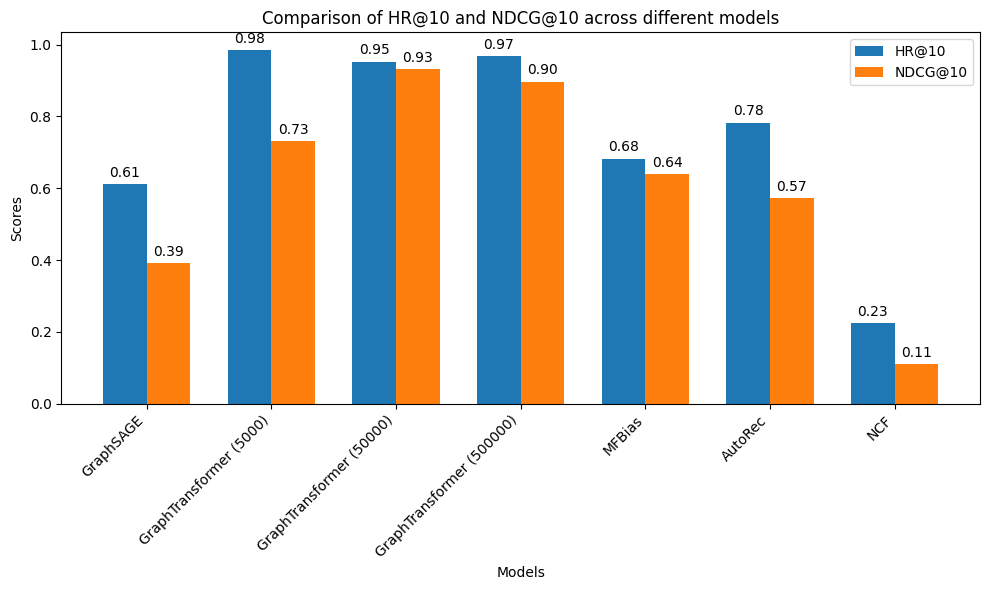

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each model
models = [
    "GraphSAGE",
    "GraphTransformer (5000)",
    "GraphTransformer (50000)",
    "GraphTransformer (500000)",
    "MFBias",
    "AutoRec",
    "NCF"
]

hr_values = [
    0.6124,  # GraphSAGE
    0.9850,  # GraphTransformer (5000)
    0.9530,  # GraphTransformer (50000)
    0.9690,  # GraphTransformer (500000)
    0.6824,  # MFBias
    0.7830,  # AutoRec
    0.2250   # NCF
]

ndcg_values = [
    0.3914,  # GraphSAGE
    0.7307,  # GraphTransformer (5000)
    0.9318,  # GraphTransformer (50000)
    0.8973,  # GraphTransformer (500000)
    0.6389,  # MFBias
    0.5736,  # AutoRec
    0.1100   # NCF
]

# Create a bar chart
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, hr_values, width, label='HR@10')
bars2 = ax.bar(x + width/2, ndcg_values, width, label='NDCG@10')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of HR@10 and NDCG@10 across different models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()

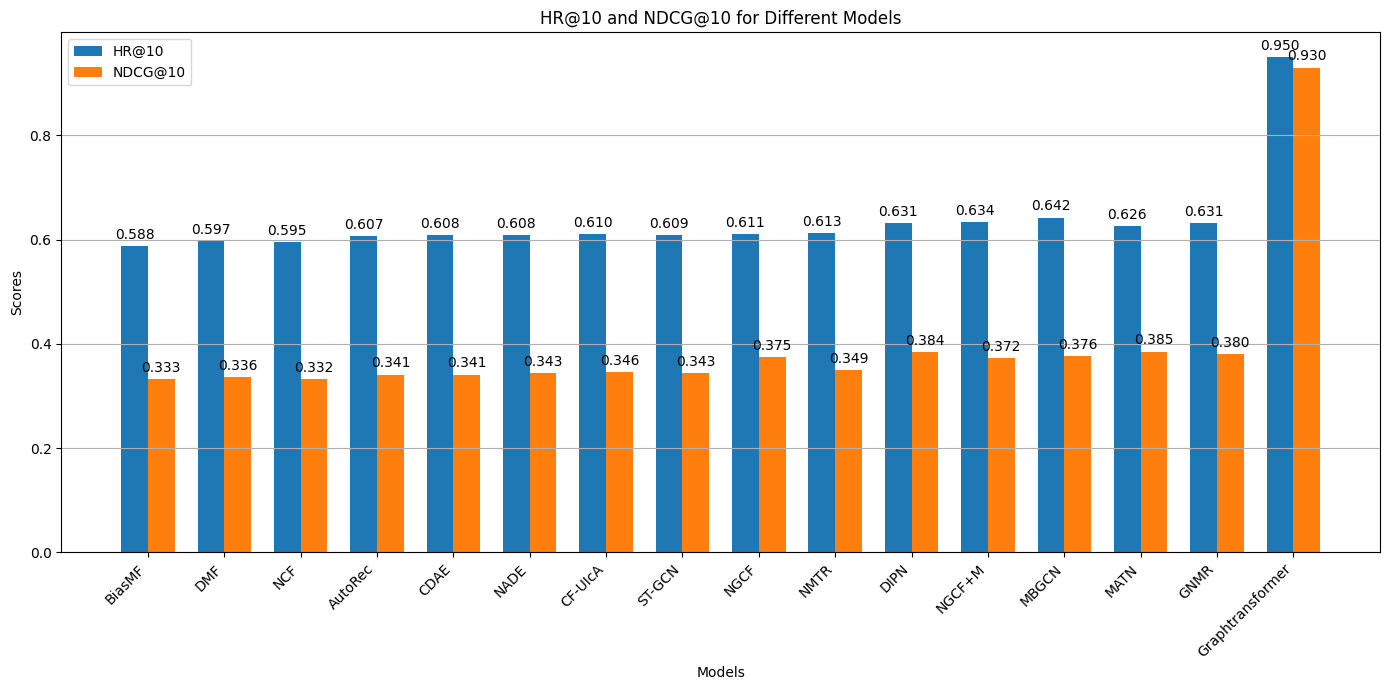

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for HR@10 and NDCG@10
hr_at_10 = [0.588, 0.597, 0.595, 0.607, 0.608, 0.608, 0.610, 0.609, 0.611, 0.613, 0.631, 0.634, 0.642, 0.626, 0.631, 0.95]
ndcg_at_10 = [0.333, 0.336, 0.332, 0.341, 0.341, 0.343, 0.346, 0.343, 0.375, 0.349, 0.384, 0.372, 0.376, 0.385, 0.380, 0.93]

# Model names
models = [
    "BiasMF", "DMF", "NCF", "AutoRec", "CDAE", "NADE", "CF-UIcA", "ST-GCN",
    "NGCF", "NMTR", "DIPN", "NGCF+M", "MBGCN", "MATN", "GNMR", "Graphtransformer"
]

# Set up the bar plot
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for HR@10 and NDCG@10
bars1 = ax.bar(x - width/2, hr_at_10, width, label='HR@10', color='#1f77b4')
bars2 = ax.bar(x + width/2, ndcg_at_10, width, label='NDCG@10', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('HR@10 and NDCG@10 for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add a grid for better readability
ax.yaxis.grid(True)

# Add value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Show plot
plt.tight_layout()
plt.show()